# 

# Picking the Best Predictive Model:  A Case Study in Analytics Operationalization 

## Part 2. Statistical Analysis and Modeling

### Author: Craig Adams
#### Contact: craig.adams@elementaryinsights.com
#### Date: July 5, 2022
_________

### Table of Contents


[Introduction](#Introduction) <br>
[Methodology](#Methodology-for-Part-2) <br>
[Results and Discussion](#Results-and-Discussion) <br>
- [The Baseline Strategy](#The-Baseline-Strategy) <br>
- [The Risk Adverse Alternative](#The-Risk-Adverse-Alternative)<br>
- [The Sensor Alert](#The-Sensor-Alert) <br>
- [Remaining Useful Life Prediction](#Remaining-Useful-Life-Prediction-with-Linear-Regression)<br>
- [Tangential Regression Modeling](#Tackling-the-Lack-of-Linearity-in-the-Data) <br>

[Summary](#Summary)<br>
[Appendix](#Appendix:-Transformations-for-Linear-Regression) <br>


###  Introduction

[go to top](#Table-of-Contents) <br>

>"*All models are wrong, some are useful, and some are more cost effective than others - Unknown*"

As detailed in Part 1, the goal of this study is to explore the development of different analytical solutions for a particular business problem, ranging from the simplest techniques to more complex ML models.  Through the exploration, the aim is to: 

1. Evaluate model performances from a technical perspective such as goodness of fit and prediction accuracy
2. Evaluate model performances from a business perspective in terms of:
    - impact on business KPIs 
    - relative cost of model development 
    - relative cost of model operationalization 

For the case study, we proposed the fictious scenario of a company, Jetsonair, who flies jet-powered drones to deliver small packages, who has data on 100 failures of their jet engines, and who wishes to understand what their options are to do better now that their customers are irate with having deliveries delayed by unplanned engine failures or in a few cases, destroyed due to a drone crash. 

The specific business objective is to find models that can predict the failures of the engines in advance so they can be removed from service before the failure, but at the same time, not give up too much of the actual available useful life of the engines (Figure 1). 
                    
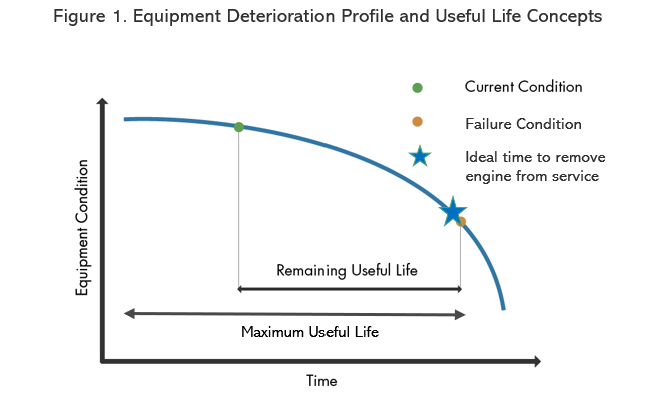


### Methodology for Part 2

[go to top](#Table-of-Contents) <br>

Working from the cleaned dataset from Part 1, four different scenarios and possible modeling approaches will be evaluated, starting with the simplest version that could be deployed and maintained.

Each one will start with a rationalization of why the approach has been considered. Then, the technical aspects (and challenges) of building the targeted model will be detailed, specifically:

 - The process to develop the model using the historical data
 - Any pertinent metrics and statistics of the model's technical performance 
 - Impact of the model on business KPIs specifically
      - operating efficiency, or the percent consumption of the available life of the fleet of engines 
      - risk of unplanned failure of one or more of the engines
      - actual count of failures within the data

Finally, commentary about the potential of the model to be deployed as a solution to the customer's challenge will be provided. Successful models will be forwarded to Part 4 for a more detailed comparison with the ML models from Part 3, which will be developed in a similar fashion.



In [1]:
### Python Configuration

# Import relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats # For Pearson, Weibull t-test
from scipy.stats import norm
from scipy.stats import exponweib, weibull_min, kstest  # For Weibull analysis

import statsmodels.api as sm  # for Regression
from statsmodels.regression import linear_model # for Linear Regression
from statsmodels.stats.diagnostic import lilliefors # For Weibull
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF

from statistics import NormalDist # for calculating overlap: pip install statistics, Python>=3.8

# Set environment variables

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (8, 6)

###  Results and Discussion

#### Data Ingestion

[go to top](#Table-of-Contents) <br>

Recall the engine failure data set that was cleaned in Part 1.  The data has been reduced to 12 sensors, 2 unit detail columns and the Remaining Useful Life or RUL metric.  There are 20,531 records for the operating cycles and 100 records for each failure event.  The last record for each engine is the failure event when the Remaining Useful Life reaches zero.


In [2]:
# Import the data from the project directory
load_file = './data/failure_cleaned.csv'
failure_df_raw = pd.read_csv(load_file)

# Display data
display(failure_df_raw.head())
print(f"The dataframe shape is {failure_df_raw.shape[0]} rows and {failure_df_raw.shape[1]} columns\n")
display(failure_df_raw.describe().T)

,unit_number,cycle_time,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


The dataframe shape is 20631 rows and 15 columns



,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,29.227633,1.0000,26.0000,52.0000,77.0000,100.0000
cycle_time,20631.0,108.807862,68.880990,1.0000,52.0000,104.0000,156.0000,362.0000
sensor_2,20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_7,20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
sensor_8,20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
sensor_11,20631.0,47.541168,0.267087,46.8500,47.3500,47.5100,47.7000,48.5300
sensor_12,20631.0,521.413470,0.737553,518.6900,520.9600,521.4800,521.9500,523.3800
sensor_13,20631.0,2388.096152,0.071919,2387.8800,2388.0400,2388.0900,2388.1400,2388.5600


For the first scenario, no further work on the data is required.


#### The Baseline Strategy

[go to top](#Table-of-Contents) <br>

The baseline business strategy in this (and all) scenarios is to do nothing.  Keep running the business as it was, maximize the operating life and asset value of each engine, and deal with the costs and consequences of the absolute certain unplanned failures. 

What this baseline strategy looks like for the case study can be better understood by graphing the distribution of operating cycles as shown below.


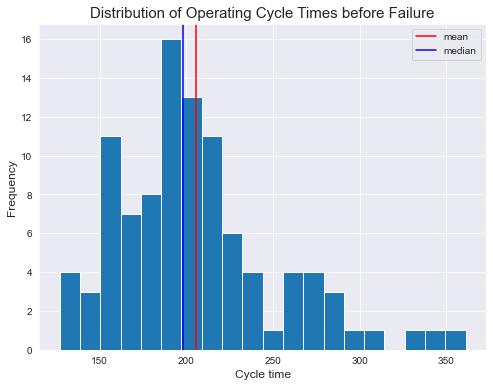

count    100.000000
mean     205.310000
std       46.342749
min      127.000000
25%      176.000000
50%      198.000000
75%      228.250000
max      361.000000
Name: RUL, dtype: float64

In [3]:
# Create copy of the cleaned dataframe
failure_df = failure_df_raw.copy()

# Extract the maximum operating cycles for each engine
max_op_cycles = failure_df.groupby('unit_number')['RUL'].max()

# Print max operating cycle distribution
plt.figure()
plt.hist(max_op_cycles, bins = 20)
plt.axvline(np.mean(max_op_cycles), label = 'mean', color = 'red')
plt.axvline(np.median(max_op_cycles), label = 'median', color = 'blue')
plt.title("Distribution of Operating Cycle Times before Failure", size=15)
plt.ylabel("Frequency", size=12)
plt.xlabel("Cycle time", size=12)
plt.legend()
plt.show()

max_op_cycles.describe()

The distribution shows that on average, the client should expect 205 operating cycles per engine, or 20,531 total operating cycles out of 100 engines before incurring failure. However, those failures will occur somewhat randomly.

 - as early as the 128th cycle 
 - as late as the 362nd cycle
 - half of the time, by the 199th cycle

It is possible in some situations that continuing to run to failure is the most cost effective solution, however running to failure not usually good for business, including in our fictious scenario:
  - costs of crashing the drone and potential loss of the asset
  - loss of business function until the drone engine or the drone itself is replaced
  - loss of reputation

Given that in our scenario that the owner of the business does not want this to happen anymore, we can move ahead and look for a data-driven solution.


#### The Risk Adverse Alternative

[go to top](#Table-of-Contents) <br>

The next scenario in terms of business sophistication is to use the historical failure data to build a simple model and find a business rule to signal replacement of the engines automatically before failure.  For example, to be super-safe, the CEO may wish to move to the other end of the operating spectrum and reduce the risk of unplanned engine failure to 1 in 100 or another acceptable low risk threshold.

A model can be developed for this scenario using a statistical technique called the [2-parameter Weibull analysis](https://www.weibull.com/basics/lifedata.htm).  Weibull distributions are [popular](https://statisticsbyjim.com/probability/weibull-distribution/#:~:text=Like%20the%20normal%20distribution%2C%20the,%2D%20and%20right%2Dskewed%20data) in the modeling of equipment failures due to the ability to fit the data to a variety of sample distribution shapes including skewed data and normal distributions.  Typically, failure data is right-skewed, with more failures earlier in the process. 

There are several tools for Weibul analysis including the stats and scipy packages in Python but the model could also theoretically be built in Excel from the root equations.  Model development here begins with isolating the failure records for the fleet into a small dataframe.

In [4]:
### Weibull curve fitting
max_cycles = failure_df.groupby('unit_number')['cycle_time'].max()

There is a stock function in the statsmodel package to fit Weibull curves to the failures.

In [5]:
# Fit Weibul model and print results
failure_model = exponweib.fit(max_cycles, floc=0)
print(failure_model)

(222.22404233045853, 0.9555862191551301, 0, 31.692498728411202)


The Weibul function returns a fitted model with four parameters, with one (location) set to zero as an acceptable default in this scenario.
- The first two parameters describing the basic shape of the distribution (222, 0.956) 
- The last parameter scales the shape to fit the data (31.7)

The fit of the curve can be checked against the statistics for the underlying distribution. 

In [6]:
# Print the mean and median value to confirm model fit
print(f"Mean cycles: {exponweib.mean(a=failure_model[0], c=failure_model[1], loc=failure_model[2], scale=failure_model[3]).round(1)}")

# Check values
print(f"Median cycles: {exponweib.median(a=failure_model[0], c=failure_model[1],loc=failure_model[2], scale=failure_model[3]).round(1)}")


Mean cycles: 206.3
Median cycles: 198.4


There appears to be a good fit with the statistical metrics (Recall from Part 1, the mean value for all cycles is 206.31, whereas the mean value of the operating cycles is 206.31 -1 or 205.31). 

The Weibull model can be used to generate and visualize the Probability Density Function and Cumulative Density Functions as shown below.

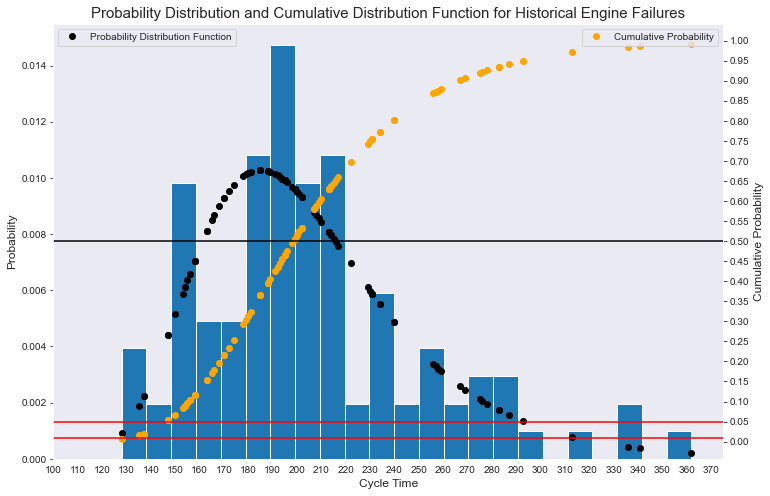

In [7]:
# Determine PDF and CDF functions
y = exponweib.pdf(max_cycles, a=failure_model[0], c=failure_model[1], loc=failure_model[2], scale=failure_model[3])
z = exponweib.cdf(max_cycles, a=failure_model[0], c=failure_model[1], loc=failure_model[2], scale=failure_model[3])

# Plot results
sns.set_style('dark')

fig, ax = plt.subplots(figsize=(12,8))
ax.hist(max_cycles, bins=23, density=True)
ax2=ax.twinx()
ax.plot(max_cycles, y, linestyle='', marker='o', label='Probability Distribution', c='black')
ax2.plot(max_cycles, z, linestyle='', marker='o', label='Cumulative Distribution', c='orange')
plt.title("Probability Distribution and Cumulative Distribution Function for Historical Engine Failures", size=15)
ax.set_xlabel("Cycle Time", size=12)
ax.set_ylabel("Probability", size=12)
ax2.set_ylabel("Cumulative Probability", size=12)
# ax2.set_ylabel("Cumulative Probability", size=12)
ax.legend(['Probability Distribution Function'], loc="upper left")
ax2.legend(['Cumulative Probability'], loc="upper right")
plt.xlim(100,375)
plt.xticks(range(100,380,10))
plt.yticks(np.arange(0,1.05,0.05))
plt.axhline(0.01, c='red')
plt.axhline(0.05, c='red')
plt.axhline(0.5, c='black')

plt.show()

Visually, the right-skew to the Weibull Probability Distribution curve in black seems to fit well with the shape of the failure data, although the sparseness of the data is clear.

The Weibull model can be used to investigate different failure risk thresholds and determine what the associated business implications might be. 


In [8]:
# Calculate the RUL associated with 1% failure
LCL = 0.01
LCL_val = exponweib.ppf(LCL, a=failure_model[0], c=failure_model[1],loc=failure_model[2], scale=failure_model[3])

print(f"Statistics for {round(LCL*100,0)}% chance of failure")
print('-'*50)
print(f"Operating Cycles at 1% chance of failure: {LCL_val.round(1)}")
print(f"Average useful life consumed: {(LCL_val/np.mean(max_cycles)*100).round(1)} %")
print(f"Lowest useful life consumed: {(np.max(max_cycles)-LCL_val).round(1)} cycles, {(LCL_val/np.max(max_cycles)*100).round(1)} %")


Statistics for 1.0% chance of failure
--------------------------------------------------
Operating Cycles at 1% chance of failure: 131.2
Average useful life consumed: 63.6 %
Lowest useful life consumed: 230.8 cycles, 36.2 %


In the first scenario, at 131 cycles, the company would have a 1% chance of failure (1 in 100, e.g. the engine with 128 cycles of operation) and all engines would be removed from service at this point to avoid further failures.  

However, the average engine would still have 75 cycles or 36.4% of its operating life remaining.  In worst case, given that the highest RUL in the historical data is 361 cycles, engines might be discarded with up to 231 cycles or 63.8% of their useful life remaining.



In [9]:
# Calculate the RUL associated with 5% failure
LCL = 0.05
LCL_val = exponweib.ppf(LCL, a=failure_model[0], c=failure_model[1],loc=failure_model[2], scale=failure_model[3])

print(f"Statistics for {round(LCL*100,0)}% chance of failure")
print('-'*50)
print(f"Average Cycles at 5% chance of failure: {LCL_val.round(1)}")
print(f"Average Engine useful life consumed: {(LCL_val/np.mean(max_cycles)*100).round(1)} %")
print(f"Lowest useful life consumed: {(np.max(max_cycles)-LCL_val).round(1)} cycles, {(LCL_val/np.max(max_cycles)*100).round(1)} %")

Statistics for 5.0% chance of failure
--------------------------------------------------
Average Cycles at 5% chance of failure: 146.3
Average Engine useful life consumed: 70.9 %
Lowest useful life consumed: 215.7 cycles, 40.4 %


Increase the risk threshold to 5 in 100, increases the replacement point to 145 cycles, with the accompanying 5 times increase in the risk of failure.  This replacement threshold still leaves 60 cycles or almost 30% of the engine life unused on average, with 60% of the engine life remaining in the worst case.

For the 15 operating hours gained per engine, or 1500 cycles for the fleet, it might be hard to justify the five fold increase in risk.

For the business scenario at hand, we'll assume that the acceptable Weibull threshold is the more conservative 1 failure in 100 or less. Note that at any time, we can reconstitute the CDF function from the parameters provided here to assess other risk levels if required.

The advantages of the Weibull approach are clear:  
- it uses a very simple dataset of engine number and cycle count at failure
- the Python code is very simple and relatively short
- there would be little need to maintain the model once the business rule was implemented as the frequency of new failures to add to the data would be very low

The disadvantages of the Weibull approach in our case study are also clear:
- a high cost to the avoidance of failures, namely a 36% increase in cost of running same distance as the baseline case of running to failure, by having to pre-maturely buy and install replacement engines.   

One final detail that must be discussed is that models like this require a Goodness-of-Fit test to confirm statistical significance.  According to some literature, it is possible to use the Kolmogorov-Smirnov (KS) method to test the hypothesis that the sample distribution comes from the theoretical distribution of the fitted model.  [Code](https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3/51742444#51742444) has been acquired to run this test and also test for goodness of fit to a normal distribution at the same time.

In [10]:
# Kolmogorov-Smirnov test for fit

def get_best_distribution(data):
    """ This function calculates the p-values for different distributions and finds the best fit
    """
    dist_names = ["norm", "exponweib"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return 

In [11]:
get_best_distribution(max_cycles)

p value for norm = 0.039376221979957604
p value for exponweib = 3.179376207271595e-51
Best fitting distribution: norm
Best p value: 0.039376221979957604
Parameters for the best fit: (206.31, 46.11045326170629)


C:\Users\Adams\.conda\envs\csadams\lib\site-packages\scipy\stats\_continuous_distns.py:1726: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


The KS p-value is very small, suggesting that the Null hypothesis must be rejected and that the data does not come from the fitted Weibull distribution after all.  Interestingly, the suggested best fit is actually a normal distribution with a mean of 206.31, a standard deviation of 46 and a p-value very close to the threshold of retaining the Null hypothesis.  This is a bit non-sensical though as the Weibull function can mimic a normal curve and chose not to, fitting a right skew to the data instead.



[Other literature](https://influentialpoints.com/Training/kolmogorov-smirnov_test-principles-properties-assumptions.htm#:~:text=The%20key%20assumptions%20of%20the,that%20it%20is%20fully%20defined) says that "If parameters are estimated from the data, the (KS) test result will be (much) too conservative. If parameters are estimated from the sample, Lilliefors test should be used instead". This test is available for normal and exponential distributions but not Weibull curves as of yet. It can be used however to confirm if the distribution better fits a normal distribution. 

In [12]:
# Score the model against a normal distribution
test2 = lilliefors(max_cycles, dist='norm', pvalmethod='table')
print(f"Lilliefors test statistic and p-value: {test2}")

Lilliefors test statistic and p-value: (0.1387846013061077, 0.0009999999999998899)


The Lilliefors p-value is lower than 0.05, so the Null hypothesis that the sample comes from a normal distribution can be rejected, which contradicts the results from the KS test.  Further work is clearly required to find a method to confirm Goodness of Fit for Weibull distributions including the case study example here.

Without a readily-available Lilliefors test for Weibull, the Goodness-of-Fit of our model cannot be confirm yet, which reduces the confidence in the model in setting a reliable business rule. But for the case study, it will be assumed that the eyeball test is sufficient and that the Weibull distribution is the most reasonable fit for now. 

The contradictory statistical testing results goes to show that even a simple statistical modeling exercise like this can have its challenges.

#### The Sensor Alert

[go to top](#Table-of-Contents) <br>

So far, the first two scenarios have not used any of the sensor data.  As detailed in Part 1, there are 21 sensors on each engine collecting information and 12 of them are potentially providing insights into each engine's health at set operating cycle intervals.  Monitoring the health of equipment in this fashion is formally known as [Condition-Based Monitoring](https://inspectioneering.com/tag/condition+based+monitoring). A simple (and appropriate) every-day analogy is the check engine light in your car:  when the light goes off, based on an underlying rule that has been determined from previous failures, the engine needs immediate servicing.

The third scenario investigates whether or not this would work for the case study at hand.  To start, the distributions of sensor values need to be examined at the end of life or RUL=0 and another distinct time farther up the Useful Life curve in Figure 1 of the Introduction.  The goal is to find a point where the two distributions have a separation.  At that point in time, there will be an associated value of a targeted sensor that could be used to trigger a threshold alert as time moves forward, allowing all engines to be replaced before failure.

A starting point for the analysis is the distribution of sensor values at 60 cycles of RUL.  The two distributions for RUL=60 and RUL=0 are plotted together as shown below, along with the kernel density estimate (smoothed) of the distributions.

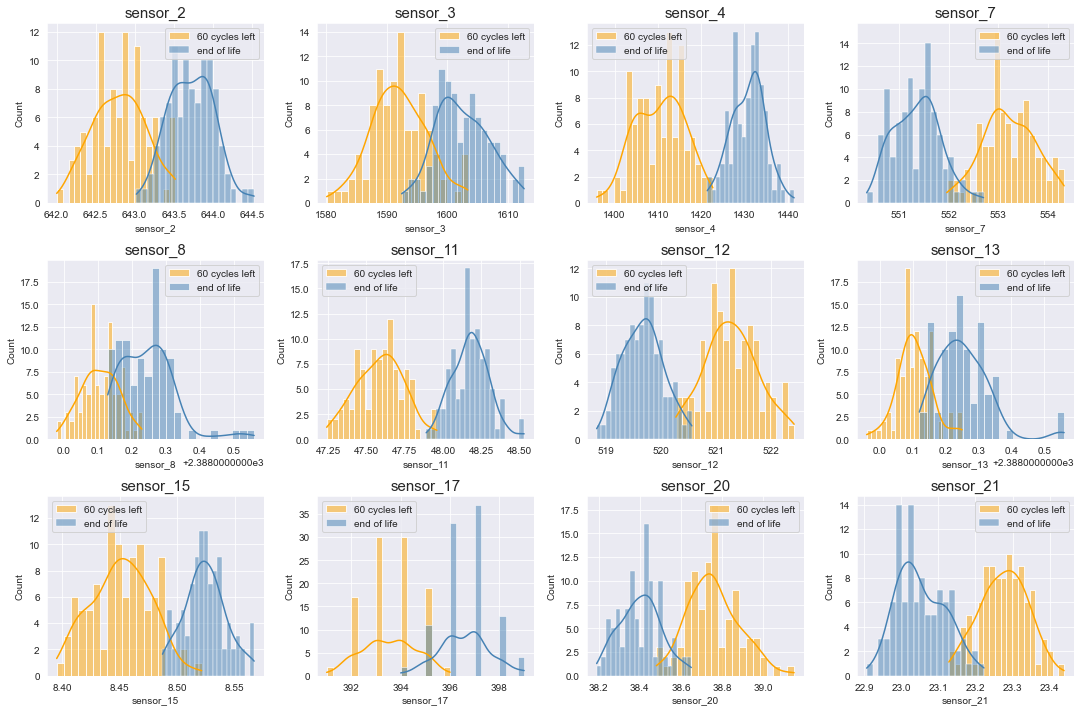

In [13]:
# Pick a RUL interval, X, for initial inspection
RUL_X = 60

# Pull the records for RUL = 0 and for RUL = X to start
RUL_0_df = failure_df[(failure_df['RUL']==0)]
RUL_X_df= failure_df[(failure_df['RUL']==RUL_X)]

# Plot the two distrubtions for a given sensor using boxplots
sensor_list = failure_df.drop(['RUL','unit_number', 'cycle_time'], axis = 1).columns
# print(sensor_list)

# Convert to grid plot for better visualization
sns.set_style('darkgrid')
rows = 3
cols = 4
count = 1
plt.subplots(rows, cols, figsize=(15, 10))
     
for sensor in sensor_list:
    plt.subplot(rows, cols, count)
    sns.histplot(RUL_X_df[sensor], kde=True, bins=20, color='orange', label = str(RUL_X)+" cycles left")
    sns.histplot(RUL_0_df[sensor], kde=True, bins=20, color='steelblue',label ='end of life')

#     plt.hist(RUL_0_df[sensor], bins = 30, alpha = 0.5, )
#     plt.hist(RUL_X_df[sensor], bins =30, alpha = 0.5, )
    plt.legend()
    plt.title(sensor, size=15)
    count += 1

plt.tight_layout()
plt.show()

The visualization shows that there are different degrees of separation between the distributions, with some that would suggest that a sensor threshold business rule might be possible. 

 - `sensor_4` and `sensor_11` are mostly separated, with `sensor 11` showing the widest difference between the two distributions
 - `sensor_7` and `sensor_12` have some separation as well, as do sensors 20 and 21 
 - in contrast, `sensor_8` and `sensor_13` have lots of overlap
 
These patterns are fully consistent with the previous observations about the sensor data in Part 1.

`Sensor 11` appears to be the best candidate for a "check engine light" model development exercise (see below for the isolated plot and the kernel density estimates of the underlying distributions).  

Some statistical tests need to be run first to check if the general approach is valid.  

In [14]:
### Pick a sensor 
sensor = 'sensor_11'

# Check distributions for normality
print(stats.shapiro(RUL_0_df[sensor]))
print(stats.shapiro(RUL_X_df[sensor]))

ShapiroResult(statistic=0.9871898889541626, pvalue=0.4505190849304199)
ShapiroResult(statistic=0.9901535511016846, pvalue=0.677010715007782)


The p-value for the Shapiro-Wilk test on the distribution of values for `sensor 11` at RUL=0 and RUL=60 is > 0.05, meaning that the Null hypothesis that the distributions are normal cannot be rejected.  This is a good result.  The next test is to see if the two normal distributions are statistically different.

In [15]:
# Check distributions for identical means, two-sided paired t-test
two_sample_test = stats.ttest_rel(RUL_0_df[sensor], RUL_X_df[sensor]) 
print(two_sample_test)

Ttest_relResult(statistic=32.169795065101106, pvalue=3.199091357206162e-54)


The t-test p-value is < 0.05 so we can reject the Null hypothesis that there isn't a difference in the mean values of the distributions either.

Based on these two tests, it is now possible to compare the overlap of the two distributions using normal curves and 3 sigma values from the mean
.  The [general concept](https://milnepublishing.geneseo.edu/natural-resources-biometrics/chapter/chapter-1-descriptive-statistics-and-the-normal-distribution/) is shown below.  The mean and standard deviations of the two normal distributions are needed for the calculation.

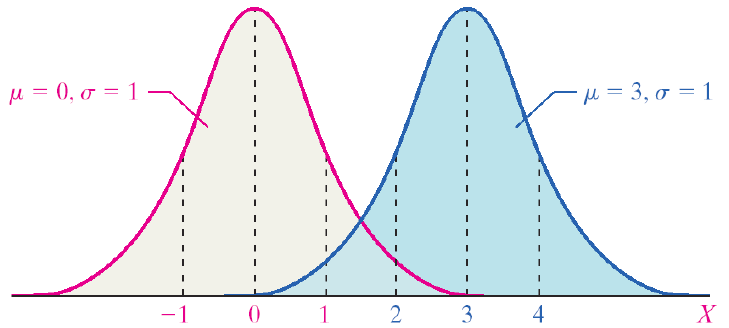


In [16]:
# Calculate the overlap of the two distributions: consolidate mean and stdev for each
mean1= RUL_X_df[sensor].mean()
sdev1=RUL_X_df[sensor].std()
mean2=RUL_0_df[sensor].mean()
sdev2=RUL_0_df[sensor].std()

# Value calculation from 'statistics' package
overlap = round(NormalDist(mean1, sdev1).overlap(NormalDist(mean2, sdev2))*100,1)
print(f"Percent overlap for the RULX=60 and RUL=0 distributions: {overlap} %")

Percent overlap for the RULX=60 and RUL=0 distributions: 3.3 %


The overlap of the full distribution for `sensor 11` at RUL=60 vs. RUL=0 is 3.3%.  Since the probability distributions fit 99.7% of the data within 3 standard deviations of the mean (two-sided), it is fair to approximate the overlap to the Z-scores of 3 and -3, or values of the mean +/- 3 sigma.  

It is therefore possible to map the overlap back to the exact sensor values.  

In [17]:
# Calculate the separation of the distributions at CI=99.7% (two-sided)

# Set Sigma value
sigma = 3

# Calculate the lower limit for RUL0 RUL_X_df[sensor].describe()

RUL_s11_threshold = RUL_X_df[sensor].mean() + sigma*RUL_X_df[sensor].std()
RUL_s11_0 = RUL_0_df[sensor].mean() - sigma*RUL_0_df[sensor].std()

# Print results
print(f"The lower limit for {sensor} at {sigma} sigma and RUL=0 is {round(RUL_s11_0,3)}\n")
print(f"The upper limit for {sensor} at {sigma} sigma at {RUL_X} remaining cycles is {round(RUL_s11_threshold,3)}\n")


The lower limit for sensor_11 at 3 sigma and RUL=0 is 47.822

The upper limit for sensor_11 at 3 sigma at 60 remaining cycles is 48.061



In [18]:
# Check back that the Z-score is accurate
x=RUL_s11_0
mean=RUL_0_df[sensor].mean()
sdev= RUL_0_df[sensor].std()

zscore = (x - mean)/sdev
print(f"Z_score for RUL=0 lower limit: {round(zscore,1)}")

Z_score for RUL=0 lower limit: -3.0


With the math established, it is now possible to probe to see at what minimum RUL value there is a full separation of the sensor distributions (with +3 sigma) compared to the RUL=0 distribution (with -3 sigma).  

In other words, if the RUL is backed further up the curve away from zero, when do the two distributions separate?  At this RUL value, a sensor alert could be set for `sensor_11`, so that when the RUL is moved forward and declines further and the `sensor_11` value rises as it does, all engines would be flagged to be removed prior to service.

At the same time, a 2 sigma difference can be evaluated as well. The iterative loop of code below generates the histogram series for the 3-sigma plots to show the progressive separation and a summary table of the results for both sigma values.

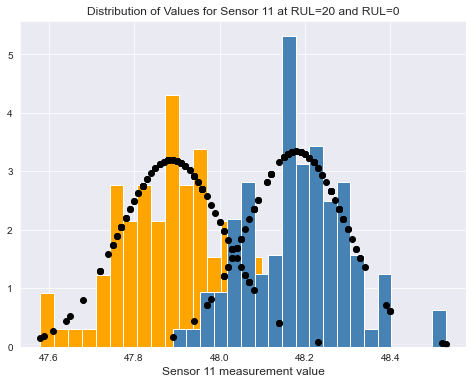

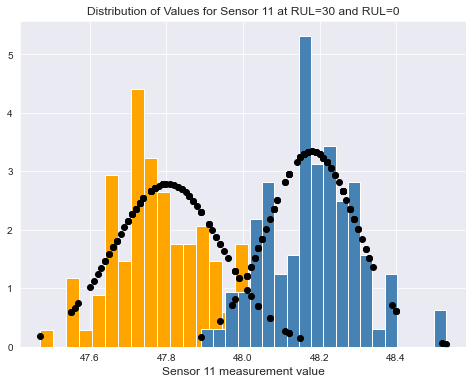

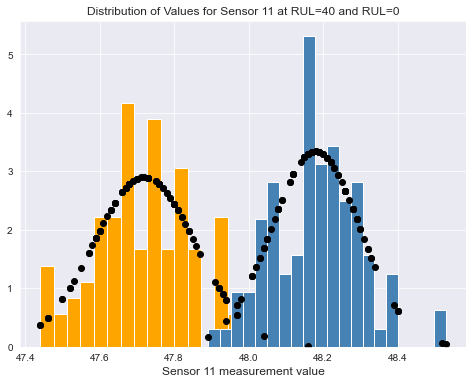

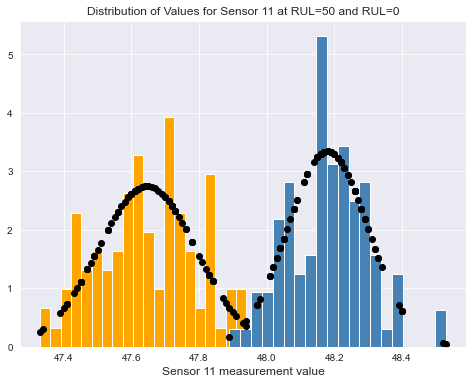

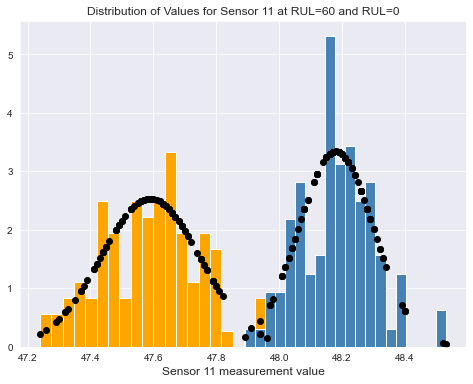

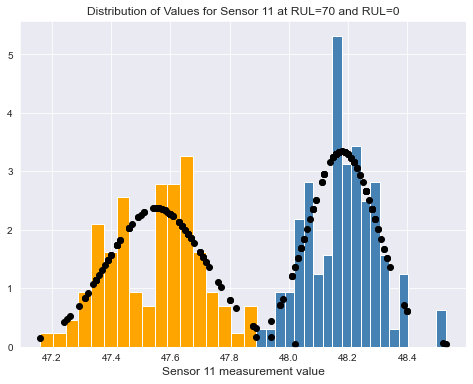

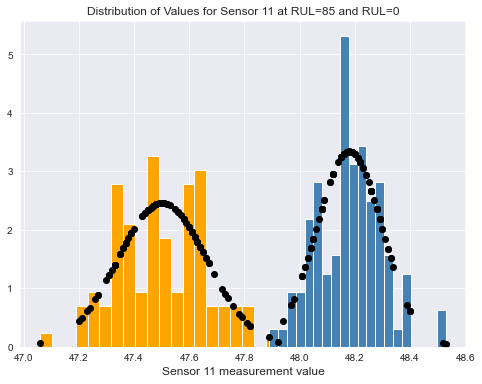

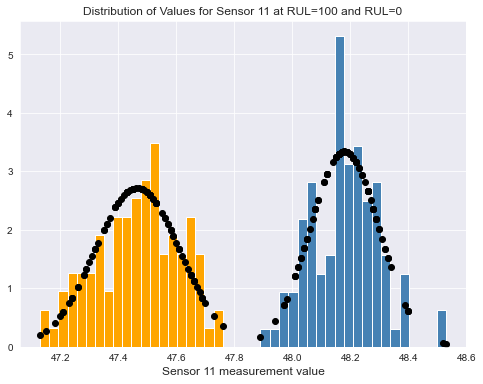

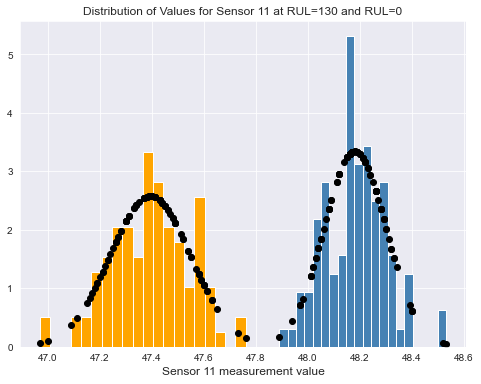

In [19]:
### Scan for other separations using sigmas of 3 and 2

# Pull the sensor 11 values records for RUL = 0 to start
RUL_0 = failure_df.loc[(failure_df['RUL']==0),'sensor_11']

# Select sigma values
sigmas = [3, 2]

# Set ranges to test 

RUL_ranges = [20,30,40,50,60,70,85,100,130]

# Save results
sigma_results = []

for sigma in sigmas:
    # Establish lower boundary for the sensor on the RUL = 0 distribution
    RUL_0_lower = RUL_0.mean()- sigma*RUL_0.std()
    
    for X in RUL_ranges:
        # Pull the records for RUL = 0 and for RUL=X to start
        RUL_X = failure_df.loc[(failure_df['RUL']==X),'sensor_11']
        # Check for normality
        p_value= round(stats.shapiro(RUL_X)[1],2)
        # Calculate two-sample-t-test  
        two_sample_test = (stats.ttest_ind(RUL_0, RUL_X, equal_var=False)[1])/2
        # Establish upper boundary for the sensor on the RUL = X distribution
        RUL_X_upper = RUL_X.mean()+ sigma*RUL_X.std()

        # Subtract the two values and save results
        difference = RUL_0_lower-RUL_X_upper 
        
        # Calculate overlap
        overlap_ratio = round(NormalDist(RUL_0.mean(), RUL_0.std()).overlap(NormalDist(RUL_X.mean(), RUL_X.std()))*100,1)
        # Save results
        sigma_results.append([sigma, X, RUL_X.mean(),RUL_X.std(), RUL_X_upper, RUL_0_lower,difference, p_value, two_sample_test, overlap_ratio])
        
        # Plot the histograms
        if sigma == 3:
#             plt.figure()
#             sns.histplot(RUL_X, kde=True, bins=20, color='orange', label=f'RUL={X}')
#             sns.histplot(RUL_0, kde=True, bins=20, color='steelblue', label='RUL=0')
#             plt.title(f"Distribution of Values with Kernel Density Estimates for Sensor 11 at RUL={X} and RUL=0")
#             plt.xlabel('Sensor 11 measurement value', size=12)
#             plt.legend()
#             plt.show()

            
#             # Plot the two distributions on the same graph
#             mean_X=
#             sdev_X=
#             mean_0=
#             sdev_0=

            plt.figure()
            plt.hist(RUL_X, density=True, bins=20, color='orange')
            plt.hist(RUL_0, density=True, bins=20, color='steelblue')
            plt.plot(RUL_X, norm.pdf(RUL_X, loc = RUL_X.mean(), scale = RUL_X.std()), 
                                                marker='o', linestyle='None', color='black')
            plt.plot(RUL_0, norm.pdf(RUL_0, loc = RUL_0.mean(), scale = RUL_0.std()), marker='o', linestyle='None', color='black')
            plt.title(f"Distribution of Values for Sensor 11 at RUL={X} and RUL=0")
            plt.xlabel('Sensor 11 measurement value', size=12)
            plt.show()

In [20]:
# Convert results to a Dataframe
sigma_results_df = pd.DataFrame(sigma_results, columns=['Sigma','RULX', 'RULX mean','RULX stdev','RULX_Z_upper','RUL0_Z_lower',
                                                  'sigma_difference','RUL-X normality p_value','t-test p-value',
                                                 '3 sigma overlap'])
# display(CI_results_df)

<Figure size 576x432 with 0 Axes>

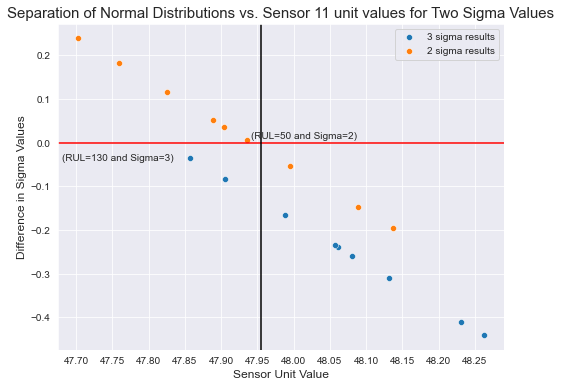

,Sigma,RULX,RULX mean,RULX stdev,RULX_Z_upper,RUL0_Z_lower,sigma_difference,RUL-X normality p_value,t-test p-value,3 sigma overlap
0,3,20,47.887700,0.124842,48.262226,47.821598,-0.440629,0.84,1.474868e-40,23.2
1,3,30,47.802400,0.142999,48.231397,47.821598,-0.409799,0.13,7.583615e-50,15.0
2,3,40,47.719600,0.137414,48.131843,47.821598,-0.310245,0.46,1.234149e-63,7.3
3,3,50,47.645500,0.145223,48.081168,47.821598,-0.259570,0.21,8.400710e-71,4.3
4,3,60,47.589200,0.157427,48.061480,47.821598,-0.239882,0.68,5.908127e-73,3.3
5,3,70,47.552400,0.168158,48.056873,47.821598,-0.235275,0.34,7.365918e-73,2.9
6,3,85,47.501500,0.162147,47.987941,47.821598,-0.166343,0.67,2.011951e-80,1.6
7,3,100,47.464900,0.146883,47.905550,47.821598,-0.083952,0.18,1.376552e-90,0.7
8,3,130,47.392626,0.154805,47.857040,47.821598,-0.035442,0.83,2.657797e-93,0.4
9,2,20,47.887700,0.124842,48.137384,47.940999,-0.196386,0.84,1.474868e-40,23.2


In [21]:
# Plot the results for sigmas = [3, 2] and RUL_ranges = [20,30,40,50,60,70,85,100,130]

plt.clf()
plt.figure()
sns.scatterplot(x=sigma_results_df.loc[(sigma_results_df['Sigma']==sigmas[0],'RULX_Z_upper')], 
                y=sigma_results_df.loc[(sigma_results_df['Sigma']==sigmas[0],'sigma_difference')], 
                label='3 sigma results')
sns.scatterplot(x=sigma_results_df.loc[(sigma_results_df['Sigma']==sigmas[1],'RULX_Z_upper')], 
                y=sigma_results_df.loc[(sigma_results_df['Sigma']==sigmas[1],'sigma_difference')], 
                label='2 sigma results')
plt.title("Separation of Normal Distributions vs. Sensor 11 unit values for Two Sigma Values", size=15)
plt.xlabel("Sensor Unit Value", size=12)
plt.ylabel("Difference in Sigma Values", size=12)
plt.axhline(0, c='red')
plt.axvline(47.955, c='black')
plt.text(47.936 +.005, 0.01, '(RUL=50 and Sigma=2)')
plt.text(47.680, -0.04, '(RUL=130 and Sigma=3)')
plt.legend()
plt.xticks(np.arange(47.7,48.3,0.05))
plt.show()

# Display the values as well for easier interpretation
display(sigma_results_df)


Several observations can be made from histograms, the table and the 2-D graph, which are admittedly hard to interpret at first glance.

- The Normality p-values all are > 0.05 meaning that Null hypothesis that RUL0 and all tested RULX distributions are normal cannot be rejected
- All t-test p_values are very small, with the smallest for RULX=130 and largest for RULX=20, but in all cases, the Null hypothesis that the distributions are the same can be rejected.  
- Unfortunately, there isn't a clean 3-sigma separation or positive 3-sigma difference between RULX and RUL0 distributions until more than 130 RUL cycles, which doesn't work for our business problem
     - setting an alert out that far will mean that we are losing an unacceptable amount of cycles, especially since the earliest failure is at 128 cycles.
- There is a positive sigma difference at RULX=50 if one accepts a 2 sigma separation and an increased overlap of 4.3% for the two distributions instead.

From this result, the best option seems to be to set the Sensor Threshold at value associated with the 2 sigma interval and RUL = 50.  This is closest to RUL = 0 so the engines won't be shut down and replaced prematurely.  However, the business can theoretically expect a risk of ~2 in 100 failures by this point as the 2 sigma threshold (97.5%) roughly corresponds to half of the overlap that belongs to the RUL=0 distribution.


The concept can be tried out on the data.  The first step is to add the sensor alert as a binary variable based on the `sensor_11` value at the RUL=50 and the 2-sigma upper value, which is 47.936.

In [22]:
# Add the binary flag to the dataset 

failure_df2 = failure_df.copy()
failure_df2['sensor_11_alert'] = np.where((failure_df2['sensor_11'] >= 47.936), 1, 0)
display(failure_df2.T)

,0,1,2,3,4,5,6,7,8,9,...,20621,20622,20623,20624,20625,20626,20627,20628,20629,20630
unit_number,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
cycle_time,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,7.0000,8.0000,9.0000,10.0000,...,191.0000,192.0000,193.0000,194.0000,195.0000,196.0000,197.0000,198.0000,199.0000,200.0000
sensor_2,641.8200,642.1500,642.3500,642.3500,642.3700,642.1000,642.4800,642.5600,642.1200,641.7100,...,643.6900,643.5300,643.0900,643.7200,643.4100,643.4900,643.5400,643.4200,643.2300,643.8500
sensor_3,1589.7000,1591.8200,1587.9900,1582.7900,1582.8500,1584.4700,1592.3200,1582.9600,1590.9800,1591.2400,...,1610.8700,1601.2300,1599.8100,1597.2900,1600.0400,1597.9800,1604.5000,1602.4600,1605.2600,1600.3800
sensor_4,1400.6000,1403.1400,1404.2000,1401.8700,1406.2200,1398.3700,1397.7700,1400.9700,1394.8000,1400.4600,...,1427.1900,1419.4800,1428.9300,1427.4100,1431.9000,1428.6300,1433.5800,1428.1800,1426.5300,1432.1400
sensor_7,554.3600,553.7500,554.2600,554.4500,554.0000,554.6700,554.3400,553.8500,553.6900,553.5900,...,551.7800,551.1400,552.0400,551.9900,551.4200,551.4300,550.8600,550.9400,550.6800,550.7900
sensor_8,2388.0600,2388.0400,2388.0800,2388.1100,2388.0600,2388.0200,2388.0200,2388.0000,2388.0500,2388.0500,...,2388.2600,2388.1700,2388.2900,2388.2300,2388.2300,2388.1900,2388.2300,2388.2400,2388.2500,2388.2600
sensor_11,47.4700,47.4900,47.2700,47.1300,47.2800,47.1600,47.3600,47.2400,47.2900,47.0300,...,48.0700,48.1800,48.1900,48.1200,48.2200,48.0700,48.0400,48.0900,48.3900,48.2000
sensor_12,521.6600,522.2800,522.4200,522.8600,522.1900,521.6800,522.3200,522.4700,521.7900,521.7900,...,519.8000,520.5900,520.1100,519.5500,519.7100,519.4900,519.6800,520.0100,519.6700,519.3000
sensor_13,2388.0200,2388.0700,2388.0300,2388.0800,2388.0400,2388.0300,2388.0300,2388.0300,2388.0500,2388.0600,...,2388.2800,2388.2100,2388.1900,2388.2200,2388.2800,2388.2600,2388.2200,2388.2400,2388.2300,2388.2600


In [23]:
def plot_RUL_histogram(col):
    """ This function plots the histogram of a dataframe's RUL column and adds statistical details
    """
    sns.set_style('darkgrid')

    plt.figure(figsize=(10,6))
    plt.hist(col, bins = 30)
    plt.title('Remaining Useful Life Frequency', size=15)
    plt.xlabel('Remaining Useful Life', size=12)
    plt.ylabel('Frequency', size=12)
    plt.axvline(col.mean(), label = 'mean', color = 'red')
    plt.axvline(col.median(), label = 'median', color = 'blue')
    plt.axvline(col.mode()[0], label = 'mode', color = 'black')
    plt.legend()
    plt.show()

    return

The data can now be filtered for the instances when the sensor alert was triggered, then sorted for when the first alert was triggered and the engine removed from service because of it.

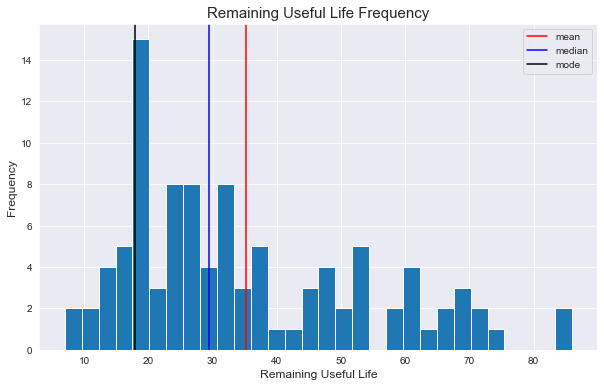

count    100.00000
mean      35.14000
std       18.82295
min        7.00000
25%       20.00000
50%       29.50000
75%       49.00000
max       86.00000
Name: RUL, dtype: float64

Engines flagged before failure: 100


In [24]:
# Extract the max RULs for the engines at the cut off
replaced_engines_with_life = failure_df2[(failure_df2['sensor_11_alert'] > 0)]
replaced_engines_life_remaining = replaced_engines_with_life.groupby('unit_number')['RUL'].max().reset_index()

# How many engines got flagged before failure?
engines_flagged = replaced_engines_life_remaining['unit_number'].nunique()

# Plot results
plot_RUL_histogram(replaced_engines_life_remaining['RUL'])

# Show stats
display(replaced_engines_life_remaining['RUL'].describe().T)

print(f"Engines flagged before failure: {engines_flagged}")

In the small-sample data set, no engines actually failed before being flagged at least once so all engines were removed from service prior to failure.  The mean RUL for the alert was with 35 cycles remaining, and the median was with ~30 cycles remaining.  The worst case was with 84 RUL cycles left, and the closest to failure was 7 cycles which is still plenty of time to arrange for replacement.

The total operating cycles that were sacrified when the engine were removed from service because of the alert can be calculated as well.


In [25]:
def RUL_business_KPIs(df_column):
    """ This function calculates the cycles remaining, total operating hours and operating efficiency from the dataframe
    extract of the engines removed from service and the RUL column, e.g. replaced_engines_life_remaining['RUL']
    """
    # Calculate unused_cycles
    unused_cycles = df_column.sum()
    print(f"Cycles remaining: {unused_cycles}")

    # Calculate business KPIs
    total_cycles = failure_df.shape[0]-100
    percent_unused_cycles = unused_cycles/total_cycles*100

    print(f"Total operating cycles for the fleet: {(100-percent_unused_cycles)/100*(failure_df.shape[0]-100)}")
    print(f"Operating efficiency: {round(100-percent_unused_cycles,1)} %")
    

In [26]:
RUL_business_KPIs(replaced_engines_life_remaining['RUL'])

Cycles remaining: 3514
Total operating cycles for the fleet: 17017.0
Operating efficiency: 82.9 %


Overall the results are quite promising:  3514 operating cycles were sacrificed, but the total operating effiency, or percentage of available cycles of the fleet that were used, jumped from 64% with the Weibul analysis to 83%.

To summarize, from statistical modeling techniques, a business rule can be implemented based on the value from a single sensor, similar to a check engine light, so that 83% of the fleet operating life could be attained.  There is some statistical risk failure e.g. about 2 in 100 based on normal distribution analysis, but none in the failure data itself. 

This is a strong gain in operating efficiency for a relatively low effort. The business rule is also readily operationalized as a "Rule of Thumb" that the engines get removed by the mechanic when the sensor reaches this value, or even better, as an automatic alert to shut the engine down when the threshold is reached during an operating cycle.  The predictive model could be re-run periodically to check the validity of the business rule and perhaps tune the threshold, especially in the event of an unexpected failure, but it would not require much attention otherwise.  The calculations needed are also relatively straight-forward thanks to the ability to use normal distribution curves.

One disadvantage of the Sensor Alert approach however is that it depends on a single sensor value, whereas there are 12 sensors worth of information that could be used to build that more sophisticated model. That fact leads us to the next option: an explicit prediction of the engine's RUL leveraging the available time series sensor data.


#### Remaining Useful Life Prediction with Linear Regression

[go to top](#Table-of-Contents) <br>

The final statistical technique to try is to model the RUL itself and use the predicted RUL value to remove the engine from service close to or at the actual RUL=0 threshold.

The most popular modelling technique for numeric data is Linear Regression.  It is easy to understand and easy to deploy even as a business rule:  Data collection and reporting systems used in industry like [OSI PI](https://www.osisoft.com/pi-system/) can calculate simple y = mx + b functions like this from incoming sensor data and send out alerts when a threshold value for y is reached. 

Building a linear regression model for this data set might be challenging given the four assumptions associated with a linear regression model when using a statistical approach:

1. **Linearity**: The relationship between the predictor and target variables to be linear.
2. **Independence/No Multicollinearity**: The predictor variables are independent of each other.
3. **Residuals** are normally distributed.**
4. **Homoscedasticity**: The variance of residual is the same for any value of X.**

The first two aspects were explored in the EDA work but will be reviewed again briefly here. 

Recall that the plots of the sensor traces for a subset of engines plotted against the RUL metric.  Ten engines are plotted in this case rather than 5 to provide more shape to the distributions. 

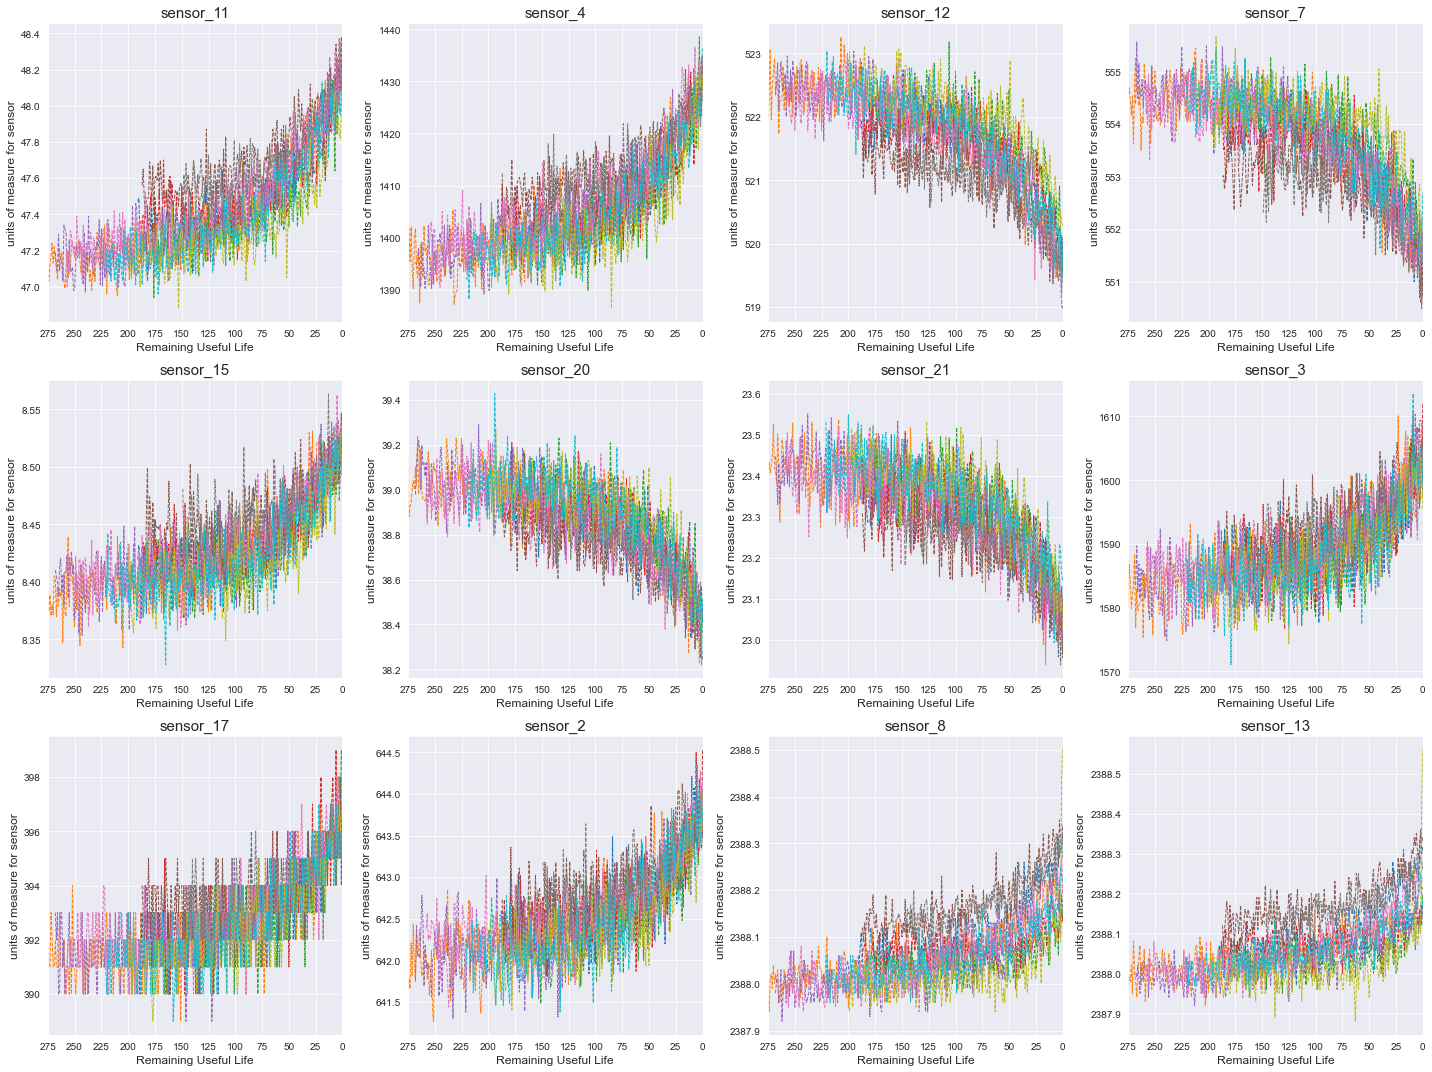

In [56]:
### Showcase lack of linearity again with scatter plots

# Set features and y, organize them for easier visualization and interpretation
X_master = failure_df[[ 'sensor_11','sensor_4','sensor_12', 'sensor_7','sensor_15', 'sensor_20', 'sensor_21', 'sensor_3',  
                     'sensor_17',   'sensor_2', 'sensor_8', 'sensor_13']]
y = failure_df['RUL']

# Pick a set of engines to display
engine_limit = 10

# Plot only that set of trajectories 
rows = 3
cols = 4
plt.subplots(rows,cols, figsize=(20,15))
plot_count = 1

for sensor in X_master.columns:
    plt.subplot(rows, cols, plot_count)
    
    for i in range(1, engine_limit+1): 
        plt.plot('RUL', sensor, data=failure_df[failure_df['unit_number']==i], linestyle = '--', linewidth = 1)

#     plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel('units of measure for sensor', size=12)
    plt.xlabel('Remaining Useful Life', size=12)
    plt.xlim(275,0)
    plt.title(sensor, size=15)
  
    plot_count += 1

plt.tight_layout()
plt.show()

There are no linear relationships between remaining sensors and RUL, all are curved. Recall next the Pearson correlation plot. 

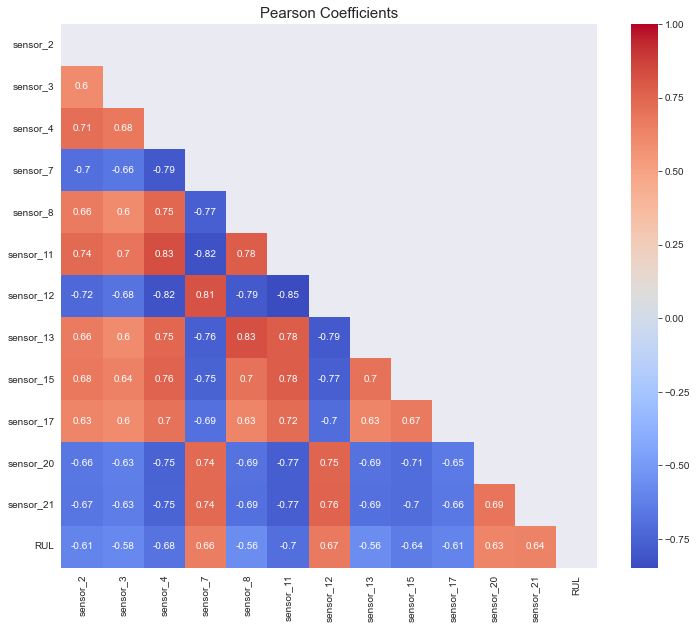

In [57]:
### Pearson Correlation Tests

# Remove unit number and cycle time from the data 
failure_df_subset = failure_df.drop(['unit_number','cycle_time'], axis=1)

# Print Pearson correlation matrix
plt.figure(figsize=(12,10))
matrix = np.triu(failure_df_subset.corr())  
sns.heatmap(failure_df_subset.corr(), vmax = 1, mask=matrix, annot = True, cmap='coolwarm')
plt.title('Pearson Coefficients', size = 15)
plt.show() 

There are lots of strong correlations, as noted previously.  The data does not pass the first two tests for Linear Regression.  Nonetheless, an attempt will be made to build a linear regression model.  Forward stepping will be used from strongest correlation to RUL (`sensor 11`) to see how adding new sensors with collinearity affects the model results especially the R2 and coefficient p-values.
 

In [58]:
### Forward loop to run Linar Regression models

# Create a revised dataframe with an organized list of columns for forward stepping
X_forwardstep = X_master

# Add the required constant column
X_forwardstep_withconstant = sm.add_constant(X_forwardstep)

# Choose target variable format:  either y, or log(y) = y2
y_train = y

# Loop through the variables and print full results

for i in range(1, len(X_forwardstep_withconstant.columns)):
    # assign the training set
    X_train = X_forwardstep_withconstant.iloc[:, 0:(i+1)]
    # instantiate and fit the model
    linreg_model = linear_model.OLS(y_train, X_train).fit()
    # save model and print results
    print(f"Cycle {i}")
    print(f"Columns included are: {X_train.columns}")
    display(linreg_model.summary())


Cycle 1
Columns included are: Index(['const', 'sensor_11'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                 1.941e+04
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0975e+05
No. Observations:               20631   AIC:                         2.195e+05
Df Residuals:                   20629   BIC:                         2.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8644.0629     61.277    141.065      0.000    8523.955    8764.171
sensor_11   -179.5550      1.289   -139.308      0.000    -182.081    -177.029
==============================================================================
Omnibus:                     2703.106   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4283.542
Skew:                           0.922   Prob(JB):                         0.00
Kurtosis:                       4.259   Cond. No.                     8.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 2
Columns included are: Index(['const', 'sensor_11', 'sensor_4'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 1.106e+04
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0907e+05
No. Observations:               20631   AIC:                         2.182e+05
Df Residuals:                   20628   BIC:                         2.182e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8840.4000     59.527    148.510      0.000    8723.722    8957.078
sensor_11   -110.0103      2.237    -49.179      0.000    -114.395    -105.626
sensor_4      -2.4860      0.066    -37.451      0.000      -2.616      -2.356
==============================================================================
Omnibus:                     2807.392   Durbin-Watson:                   0.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4604.733
Skew:                           0.934   Prob(JB):                         0.00
Kurtosis:                       4.368   Cond. No.                     2.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 3
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     7636.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0889e+05
No. Observations:               20631   AIC:                         2.178e+05
Df Residuals:                   20627   BIC:                         2.178e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2379.1941    580.675     -4.097      0.000   -3517.363   -1241.025
sensor_11    -83.3527      2.607    -31.969      0.000     -88.463     -78.242
sensor_4      -1.9617      0.071    -27.588      0.000      -2.101      -1.822
sensor_12     17.6704      0.910     19.422      0.000      15.887      19.454
==============================================================================
Omnibus:                     2828.544   Durbin-Watson:                   0.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4639.519
Skew:                           0.940   Prob(JB):                         0.00
Kurtosis:                       4.365   Cond. No.                     2.64e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 4
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     5831.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0879e+05
No. Observations:               20631   AIC:                         2.176e+05
Df Residuals:                   20626   BIC:                         2.176e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6948.7251    662.992    -10.481      0.000   -8248.242   -5649.208
sensor_11    -71.2349      2.734    -26.053      0.000     -76.594     -65.876
sensor_4      -1.7197      0.073    -23.612      0.000      -1.862      -1.577
sensor_12     13.8114      0.946     14.597      0.000      11.957      15.666
sensor_7      10.2366      0.728     14.064      0.000       8.810      11.663
==============================================================================
Omnibus:                     2860.652   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4718.587
Skew:                           0.946   Prob(JB):                         0.00
Kurtosis:                       4.381   Cond. No.                     3.23e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 5
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     4783.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0865e+05
No. Observations:               20631   AIC:                         2.173e+05
Df Residuals:                   20625   BIC:                         2.174e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3136.9112    697.369     -4.498      0.000   -4503.810   -1770.012
sensor_11    -61.3268      2.781    -22.054      0.000     -66.777     -55.876
sensor_4      -1.4918      0.074    -20.259      0.000      -1.636      -1.347
sensor_12     11.0627      0.954     11.592      0.000       9.192      12.933
sensor_7       8.3733      0.732     11.444      0.000       6.939       9.807
sensor_15   -253.4521     15.243    -16.627      0.000    -283.330    -223.574
==============================================================================
Omnibus:                     2891.424   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4785.670
Skew:                           0.953   Prob(JB):                         0.00
Kurtosis:                       4.390   Cond. No.                     3.42e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 6
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15',
       'sensor_20'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     4041.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0857e+05
No. Observations:               20631   AIC:                         2.172e+05
Df Residuals:                   20624   BIC:                         2.172e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3901.4038    697.500     -5.593      0.000   -5268.558   -2534.250
sensor_11    -54.7921      2.820    -19.431      0.000     -60.319     -49.265
sensor_4      -1.3475      0.074    -18.141      0.000      -1.493      -1.202
sensor_12      9.5183      0.959      9.927      0.000       7.639      11.398
sensor_7       7.2118      0.735      9.813      0.000       5.771       8.652
sensor_15   -228.8304     15.315    -14.941      0.000    -258.850    -198.811
sensor_20     38.4037      3.088     12.437      0.000      32.351      44.456
==============================================================================
Omnibus:                     2931.295   Durbin-Watson:                   0.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4885.244
Skew:                           0.961   Prob(JB):                         0.00
Kurtosis:                       4.410   Cond. No.                     3.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 7
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15',
       'sensor_20', 'sensor_21'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     3522.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0848e+05
No. Observations:               20631   AIC:                         2.170e+05
Df Residuals:                   20623   BIC:                         2.170e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4490.4708    695.697     -6.455      0.000   -5854.091   -3126.851
sensor_11    -48.1797      2.848    -16.914      0.000     -53.763     -42.597
sensor_4      -1.2178      0.075    -16.336      0.000      -1.364      -1.072
sensor_12      7.7481      0.963      8.044      0.000       5.860       9.636
sensor_7       6.0266      0.737      8.180      0.000       4.583       7.471
sensor_15   -207.0942     15.329    -13.510      0.000    -237.140    -177.048
sensor_20     34.3142      3.088     11.110      0.000      28.261      40.368
sensor_21     70.6781      5.161     13.696      0.000      60.563      80.793
==============================================================================
Omnibus:                     2940.176   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4908.571
Skew:                           0.963   Prob(JB):                         0.00
Kurtosis:                       4.415   Cond. No.                     3.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 8
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15',
       'sensor_20', 'sensor_21', 'sensor_3'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     3125.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0840e+05
No. Observations:               20631   AIC:                         2.168e+05
Df Residuals:                   20622   BIC:                         2.169e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2254.4887    715.454     -3.151      0.002   -3656.835    -852.142
sensor_11    -44.3051      2.854    -15.522      0.000     -49.900     -38.711
sensor_4      -1.1182      0.075    -14.972      0.000      -1.265      -0.972
sensor_12      6.7611      0.963      7.022      0.000       4.874       8.648
sensor_7       5.3229      0.736      7.232      0.000       3.880       6.766
sensor_15   -191.2277     15.323    -12.480      0.000    -221.262    -161.194
sensor_20     31.8108      3.083     10.318      0.000      25.768      37.854
sensor_21     65.0620      5.160     12.608      0.000      54.947      75.177
sensor_3      -0.9824      0.078    -12.589      0.000      -1.135      -0.829
==============================================================================
Omnibus:                     2965.723   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4975.626
Skew:                           0.968   Prob(JB):                         0.00
Kurtosis:                       4.430   Cond. No.                     5.01e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 9
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15',
       'sensor_20', 'sensor_21', 'sensor_3', 'sensor_17'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     2816.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0832e+05
No. Observations:               20631   AIC:                         2.167e+05
Df Residuals:                   20621   BIC:                         2.167e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -148.9287    732.576     -0.203      0.839   -1584.836    1286.978
sensor_11    -40.5019      2.860    -14.161      0.000     -46.108     -34.896
sensor_4      -1.0225      0.075    -13.670      0.000      -1.169      -0.876
sensor_12      5.9293      0.962      6.166      0.000       4.045       7.814
sensor_7       4.5288      0.736      6.153      0.000       3.086       5.972
sensor_15   -172.7190     15.338    -11.261      0.000    -202.783    -142.655
sensor_20     29.2231      3.079      9.492      0.000      23.189      35.258
sensor_21     59.3882      5.161     11.507      0.000      49.272      69.505
sensor_3      -0.9082      0.078    -11.647      0.000      -1.061      -0.755
sensor_17     -4.0428      0.325    -12.453      0.000      -4.679      -3.406
==============================================================================
Omnibus:                     2980.967   Durbin-Watson:                   0.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5004.746
Skew:                           0.972   Prob(JB):                         0.00
Kurtosis:                       4.430   Cond. No.                     5.23e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 10
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15',
       'sensor_20', 'sensor_21', 'sensor_3', 'sensor_17', 'sensor_2'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     2551.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0829e+05
No. Observations:               20631   AIC:                         2.166e+05
Df Residuals:                   20620   BIC:                         2.167e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6030.9899   1017.411      5.928      0.000    4036.783    8025.197
sensor_11    -37.4228      2.876    -13.010      0.000     -43.061     -31.785
sensor_4      -0.9613      0.075    -12.818      0.000      -1.108      -0.814
sensor_12      5.0845      0.965      5.271      0.000       3.194       6.975
sensor_7       4.0845      0.736      5.546      0.000       2.641       5.528
sensor_15   -162.3713     15.356    -10.574      0.000    -192.470    -132.273
sensor_20     27.5400      3.079      8.944      0.000      21.505      33.575
sensor_21     55.8906      5.167     10.816      0.000      45.762      66.019
sensor_3      -0.8714      0.078    -11.179      0.000      -1.024      -0.719
sensor_17     -3.8429      0.325    -11.829      0.000      -4.480      -3.206
sensor_2      -9.0307      1.034     -8.736      0.000     -11.057      -7.005
==============================================================================
Omnibus:                     2991.266   Durbin-Watson:                   0.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5037.306
Skew:                           0.973   Prob(JB):                         0.00
Kurtosis:                       4.440   Cond. No.                     7.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 11
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15',
       'sensor_20', 'sensor_21', 'sensor_3', 'sensor_17', 'sensor_2',
       'sensor_8'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     2376.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0815e+05
No. Observations:               20631   AIC:                         2.163e+05
Df Residuals:                   20619   BIC:                         2.164e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.202e+05   1.95e+04    -16.427      0.000   -3.58e+05   -2.82e+05
sensor_11    -44.5117      2.888    -15.411      0.000     -50.173     -38.850
sensor_4      -1.0632      0.075    -14.226      0.000      -1.210      -0.917
sensor_12      8.5155      0.980      8.691      0.000       6.595      10.436
sensor_7       6.3830      0.744      8.576      0.000       4.924       7.842
sensor_15   -176.3420     15.275    -11.544      0.000    -206.283    -146.401
sensor_20     29.5997      3.061      9.670      0.000      23.600      35.599
sensor_21     59.5274      5.137     11.587      0.000      49.458      69.597
sensor_3      -0.8425      0.077    -10.878      0.000      -0.994      -0.691
sensor_17     -3.7431      0.323    -11.598      0.000      -4.376      -3.110
sensor_2      -9.8328      1.028     -9.566      0.000     -11.848      -7.818
sensor_8     135.6911      8.097     16.759      0.000     119.821     151.562
==============================================================================
Omnibus:                     3050.620   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5251.737
Skew:                           0.978   Prob(JB):                         0.00
Kurtosis:                       4.510   Cond. No.                     2.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cycle 12
Columns included are: Index(['const', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15',
       'sensor_20', 'sensor_21', 'sensor_3', 'sensor_17', 'sensor_2',
       'sensor_8', 'sensor_13'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     2200.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:13   Log-Likelihood:            -1.0809e+05
No. Observations:               20631   AIC:                         2.162e+05
Df Residuals:                   20618   BIC:                         2.163e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.47e+05   2.28e+04    -19.627      0.000   -4.92e+05   -4.02e+05
sensor_11    -47.2349      2.892    -16.335      0.000     -52.903     -41.567
sensor_4      -1.1010      0.075    -14.755      0.000      -1.247      -0.955
sensor_12     10.0365      0.987     10.164      0.000       8.101      11.972
sensor_7       7.2364      0.747      9.693      0.000       5.773       8.700
sensor_15   -180.4009     15.238    -11.839      0.000    -210.269    -150.532
sensor_20     30.4384      3.054      9.968      0.000      24.453      36.424
sensor_21     61.1821      5.126     11.937      0.000      51.136      71.229
sensor_3      -0.8293      0.077    -10.736      0.000      -0.981      -0.678
sensor_17     -3.7108      0.322    -11.529      0.000      -4.342      -3.080
sensor_2     -10.1632      1.026     -9.910      0.000     -12.173      -8.153
sensor_8      93.9888      8.968     10.480      0.000      76.410     111.567
sensor_13     94.4003      8.834     10.686      0.000      77.085     111.715
==============================================================================
Omnibus:                     3047.246   Durbin-Watson:                   0.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5249.363
Skew:                           0.977   Prob(JB):                         0.00
Kurtosis:                       4.513   Cond. No.                     2.96e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The following observations can be made by scrolling through the progressive model results:

- The base model with `sensor 11` has an R2 of 0.485, which means almost half of the variance in RUL is explained by this sensor alone.
- The addition of other sensors adds progressively less improvement to the R2 scores with a p-value of the constant above 0.05 at 75% of the way through the stepping (9th step)
- Interestingly, the model with all sensors has a R2 of 0.579, with no p-values above 0.05, suggesting the full model is ok to deploy despite all other signs signalling otherwise at this point

The ability of the models to accurately predict RUL needs to be tested to see if the models might actually be useful. To reduce the obvious inclusion of interdepedent sensors, a two-sensor model will be chosen, one from each Group with opposite trending with RUL (`sensor_11` and `sensor_12`). An additional advantage of a simpler 2-sensor model is that the explainability is high for possible deployment in a business rule format: 

$$ \hat{y} = b0 + b1 sensor_1 + b2 sensor_2  $$


In [59]:
### Build best model, keep it simple: sensors 11 and 12, with opposite patterns.

# Subset data
X_best_model = X_forwardstep[['sensor_11','sensor_12']]
X_best_model_withconstant = sm.add_constant(X_best_model)

# Choose target variable format
y_train = y

# Add constant
X_train = X_best_model_withconstant

# Instantiate and fit the model
linreg_model_best = linear_model.OLS(y_train, X_train).fit()

# Save model and print results
print("Two sensor regression model:")
print(f"Columns included are: {X_train.columns}")
display(linreg_model_best.summary())

# Predict on training data 
y_pred_train = linreg_model_best.predict(X_best_model_withconstant)

Two sensor regression model:
Columns included are: Index(['const', 'sensor_11', 'sensor_12'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                 1.068e+04
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:13:16   Log-Likelihood:            -1.0926e+05
No. Observations:               20631   AIC:                         2.185e+05
Df Residuals:                   20628   BIC:                         2.186e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8561.9951    545.464    -15.697      0.000   -9631.148   -7492.842
sensor_11   -115.9459      2.367    -48.990      0.000    -120.585    -111.307
sensor_12     27.1992      0.857     31.735      0.000      25.519      28.879
==============================================================================
Omnibus:                     2778.175   Durbin-Watson:                   0.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4465.982
Skew:                           0.936   Prob(JB):                         0.00
Kurtosis:                       4.300   Cond. No.                     8.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The plot below shows the relationship between the model's predicted values of RUL and the actual values, with the black line representing the ideal line of fit.


In [60]:
def plot_actual_versus_prediction(y_actual, y_pred, RUL_X=300, c=1):
    """ This function plots the predicted RUL values against the values for the preceding linear regression model
    """
    # plot the results against training set...
    a = np.arange(0,RUL_X,0.1)
    b = a*c
    c = 1
    
    # plot the actuals vs. predicted
    plt.figure(figsize=(8,6))
    plt.scatter(y_actual, y_pred)
    plt.title('Predicted vs. Actual RUL Values', size=15)
    plt.xlabel('Actual RUL', size=12)
    plt.ylabel('Predicted RUL', size=12)
    plt.plot(a, b, color='black')
    plt.show()
    

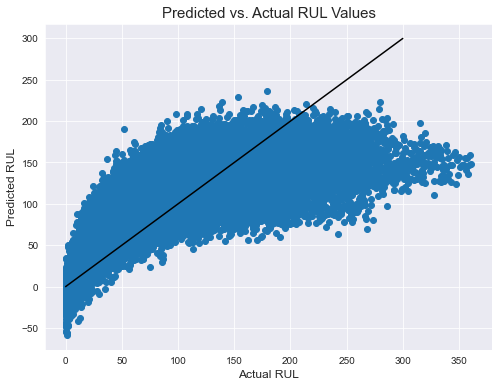

In [61]:
plot_actual_versus_prediction(y_train, y_pred_train)

The chart unfortunately reveals that the model does not predict the RUL very well, with the values underpredicted at RUL above 150 and a wide spread of predicted values (e.g +25 / -60) at actual RUL=0.  This result is not really surprising given the lack of linear relationships between the sensors and the RUL metric.

For completeness, the final two requirements for linearity can be checked whether the residuals are normally distributed, and whether the variance of residual is the same across the full range of RUL values (homoscedasticity).

The normality of the residual distribution can be plotted in histogram and Q-Q plot formats, along with the Shapiro-Wilk test for normality.  The final plot below is the residual variances for the homoscedasticity test.

In [33]:
def residual_check(model):
    """ This function plots the residuals and Shapiro Wilkes test results for the preceding linear regression model
    """
    # Plotting the residuals of the model 3.1.2
    plt.figure()
    plt.hist(model.resid, bins = 35)
    plt.title('Distribution of residual values')
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # Normal Q-Q plot
    plt.figure()
    stats.probplot(model.resid, dist="norm", plot = plt)
    plt.show()

    # Calculate the Shapiro-Wilk test statisic and its p-value
    print("Shapiro-Wilk Test: ", stats.shapiro(model.resid))

    # Plot the residuals and the predicted values:  Test for homoscedasticity
    plt.figure()
    plt.scatter(model.fittedvalues, model.resid, alpha=0.1)
    plt.title("Homoscedasticity Plot")
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.show()
    

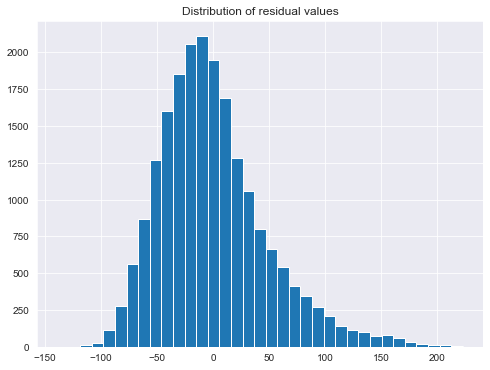

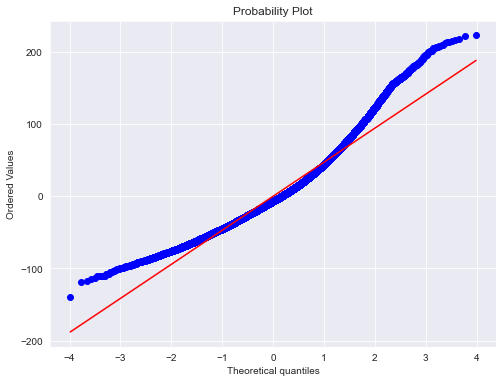

Shapiro-Wilk Test:  ShapiroResult(statistic=0.9541512131690979, pvalue=0.0)


C:\Users\Adams\.conda\envs\csadams\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


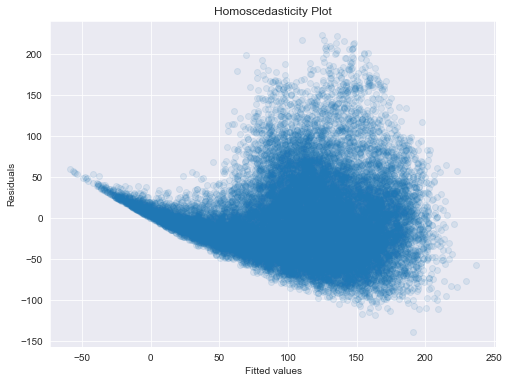

In [34]:
residual_check(linreg_model_best)

Not surprisingly, the residuals do not visually appear to fit a normal distribution in the histogram (right-skewed) or Q-Q plot (very few of the data points align with the straight red line).  The null hypothesis for the Shapiro-Wilk test that the data are normally distributed must also be rejected.  Finally, the plot of residuals vs. fitted values have a clear pattern and shape across the RUL values and are far from homoscedastic.  

Linear Regression with the as-is sensor values and full data set does not look to be a viable approach.

#### Tackling the Lack of Linearity in the Data

[go to top](#Table-of-Contents) <br>

There are ways to straighten out curved data through log or exponential transformations in order to generate linear relationships with a target variable. With the 'linearized" data, it is possible to generate linear regression models that fit the data much better and pass the four tests for statistical significance.

Transformations were attempted on the two representatives sensors in the model, as described in the Appendix.  In short summary, `sensor_12` can be "linearized" through an exponential transformation but not `sensor 11`.  However, the new distribution for `sensor_12` is extremely wide and shaped like a funnel.  The model built from the transformed data has a very low  R2 of 0.19 and the model still does not pass the significance tests.  

There is however another way to deal with curved data, one that might generate a viable linear regression model: subsetting the data close to RUL=0 so that the generated predictions might lie on a tangent to the curve.  The concept is shown below with the black line representing the general idea of the tangential model.

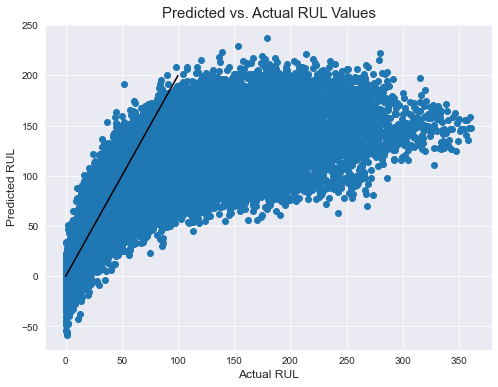

In [35]:
# Visualize Tangent Concept on training data
y_pred_train = linreg_model_best.predict(X_best_model_withconstant)
plot_actual_versus_prediction(y_train, y_pred_train, RUL_X=100, c=2)


Given the simplicity of deploying linear regression models, building a tangential model for the case study is worth a try.  To start, a cutoff value for RUL needs to be chosen.  By inspection, a RUL=50 cutoff is a reasonable place to start.

In [36]:
# Set RUL tangent to test 
RUL_tangent= 50

# Extract data
print('-'*80)
print(f"Tangent taken at {RUL_tangent}:")
failure_df_subset = failure_df[(failure_df['RUL'] <= RUL_tangent)]
# subset further for sensors 11 and 12 only
X_subset = failure_df_subset[['sensor_11','sensor_12']]
# reset y
y_subset = failure_df_subset['RUL']

# Calculate the % data being used
print(f"Percent of data in RUL subset: {round(failure_df_subset.shape[0]/failure_df.shape[0]*100,1)} %")

--------------------------------------------------------------------------------
Tangent taken at 50:
Percent of data in RUL subset: 24.7 %


About 25% of the data is left for building a model, which is the next step.

In [37]:
# train the model and report results
X_subset_wc = sm.add_constant(X_subset)
linreg_subset = linear_model.OLS(y_subset, X_subset_wc).fit()
print(linreg_subset.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     3822.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:02:53   Log-Likelihood:                -18615.
No. Observations:                5100   AIC:                         3.724e+04
Df Residuals:                    5097   BIC:                         3.726e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2053.0010    206.309     -9.951      0.0

The two-sensor tangential model has a better R2 of 0.60, versus 0.51 for the full dataset.  The coefficient p-values are all below the threshold of 0.05.

The predicted values from this model can be plotted against the actual values as before.


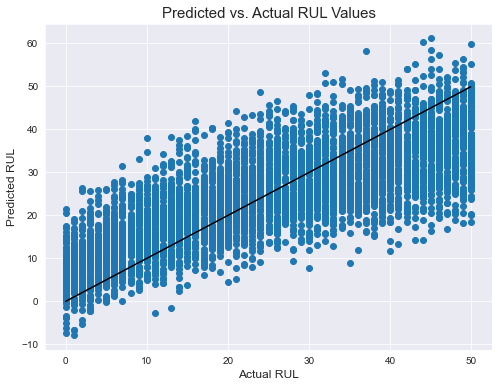

In [38]:
# Predict the RUL values
y_pred_train_subset = linreg_subset.predict(X_subset_wc)

# Plot the results
plot_actual_versus_prediction(y_subset, y_pred_train_subset, RUL_X=RUL_tangent)


The fit of the data is much better, although the model still underpredicts the actual RUL values at 50 and overpredicts them as RUL approaches zero. 

An important next step from a business perspective is to visualize the distribution at RUL=0, in order to see how well the model predicted the end of life of the engines.

In [39]:
# Put the y data together and filter for only RUL =0

y_results = list(zip(y_subset,y_pred_train_subset))
y_results_df = pd.DataFrame(y_results, columns = ['y_actual','y_pred'])
# display(y_results_df)

# Extract the RUL=0 data
y_results_RUL0 = y_results_df[y_results_df['y_actual']==0]
# display(y_results_RUL0)


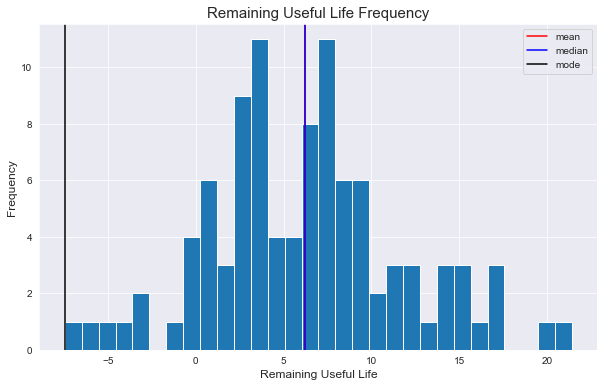

count    100.000000
mean       6.243194
std        5.627800
min       -7.455612
25%        2.972105
50%        6.228757
75%        9.224010
max       21.433265
Name: y_pred, dtype: float64

In [40]:
plot_RUL_histogram(y_results_RUL0['y_pred'])

display(y_results_RUL0['y_pred'].describe())

As suggested by the plot of predicted vs. actual values, the predicted values cover a wide range with seven negative values and four more at RUL=0, in addition to values above 20.  This is better than the model from the full dataset, but still quite erratic and not acceptable for deployment.  

But what about using a threshold?  As per the moto 'All models are wrong, but some are useful' could the model be used to predict RUL values, and when a certain X threshold value is reached, the engine could be removed from service?   In other words, the first time the model predicts a RUL value at or below the threshold, a regression-based "check engine" light alert is sent out and the engine is removed from service.

The concept might work in this case since the regression model predicts higher than the actual values as RUL approaches zero.

The concept can be tested by choosing an arbitrary RUL prediction threshold of 15.  This translates to giving the model 15 opportunities to correctly predict a RUL value of 15 or below before the actual RUL reaches zero.

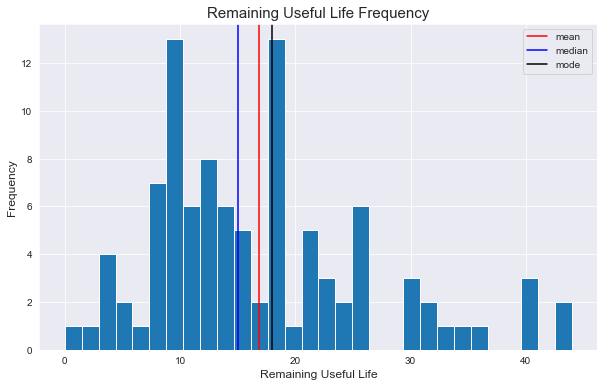

count    99.000000
mean     16.868687
std       9.594478
min       0.000000
25%      10.000000
50%      15.000000
75%      21.000000
max      44.000000
Name: RUL, dtype: float64

Failed engines: 1


In [41]:
# Set RUL threshold for the alert
threshold = 15

# Compile the model results and RUL=50 data into a dataframe 
RUL_reg_df = pd.DataFrame(columns = ['unit_number','RUL', 'est_RUL'])
RUL_reg_df['unit_number'] = failure_df_subset['unit_number']
RUL_reg_df['RUL'] = y_subset
RUL_reg_df['est_RUL'] = y_pred_train_subset
RUL_reg_df['RUL_diff'] = RUL_reg_df['est_RUL'] - RUL_reg_df['RUL']

# Add alert
RUL_reg_df['linreg_flag'] = np.where(RUL_reg_df['est_RUL'] <= threshold,1,0)

# Extract the records for the engines flagged by the alert 
replaced_engines_with_life = RUL_reg_df[(RUL_reg_df['linreg_flag'] ==1)]

# Find the first record where the flag went off
replaced_engines_life_remaining = replaced_engines_with_life.groupby('unit_number')['RUL'].max().reset_index()

# Plot results
plot_RUL_histogram(replaced_engines_life_remaining['RUL'])

# Show stats
display(replaced_engines_life_remaining['RUL'].describe().T)
failures = 100 - replaced_engines_life_remaining['unit_number'].nunique()
print(f"Failed engines: {failures}")

Setting a threshold at RUL 15 seems to have worked.  All but one of the engines was flagged before failing and had predicted RUL values at or below 15 at least once prior to the actual RUL reaching zero. The distribution of RUL is tighter than the one generated by the `sensor_11` model as well, with the mean value shifting from 35 to 16 and the maximum cycles lost dropping from 86 to 44.  The impact of the tighter distribution on the business KPIs can be calculated. 

In [42]:
# Calculate Operating Efficiency
RUL_business_KPIs(replaced_engines_life_remaining['RUL'])

Cycles remaining: 1670
Total operating cycles for the fleet: 18861.0
Operating efficiency: 91.9 %


The tighter distribution translates to an increase in operating hours to 92% from the 83% with the sensor alert.  However, the more conservative sensor alert distribution did not have a failure.  

The data for the failed engine should be extracted and reviewed.

In [43]:
# Find the engines that were removed
flagged_engines = replaced_engines_life_remaining['unit_number'].unique()

# How many engines had RUL = 0 and flag status = 0?  
failed_engines = RUL_reg_df[(RUL_reg_df['RUL']<1)& (RUL_reg_df['linreg_flag']==0)].sort_values(by='unit_number')

# Find the engine not in the flagged engine list
missing_engine = failed_engines[~failed_engines['unit_number'].isin(flagged_engines)]
missing_engine

,unit_number,RUL,est_RUL,RUL_diff,linreg_flag
9495,48,0,20.444689,20.444689,0


The tangential regression model missed flagging this engine by over 20 cycles in the final attempt, which is alarmingly poor.

The tangential model also needs to be checked for residual fit and homoscedasticity.


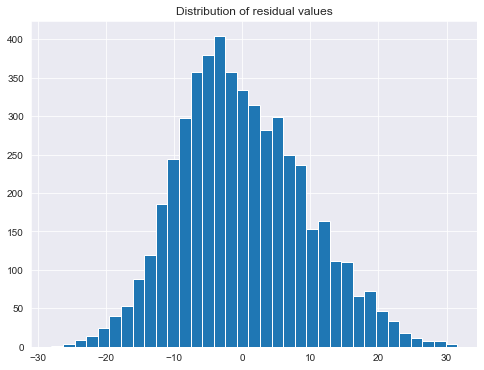

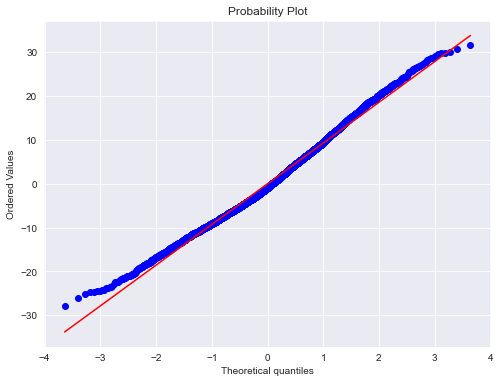

Shapiro-Wilk Test:  ShapiroResult(statistic=0.9920912981033325, pvalue=2.918006268676199e-16)


C:\Users\Adams\.conda\envs\csadams\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


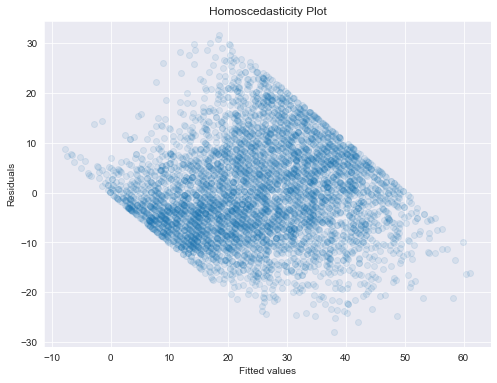

In [44]:
# Check the residuals too
residual_check(linreg_subset)


The residual plots look to fit a normal distribution much better than before, as does the homoscedascity plot, but the S-W test for Goodness of Fit to a normal distribution has a p-value below 0.05 meaning that the Null hypothesis of normality for the residuals still must be rejected.

Given this and the wide miss on flagging the failed engine despite having 15 attempts to do so, the confidence in deploying the Regression Alert from the tangential model is unfortunately low. Further experimentation with RUL tangent and failure thresholds using the code block above did not improve model performance particularly in terms of statistical tests for significance.  For example:

- Decreasing the RUL failure threshold from 15 to 10 at RUL tangent 50, resulted 2 failures and 7 more engines at the RUL=0 mark.
- Increasing the RUL tangent to 65 and the threshold to 20 did not generate any failures, but the operating efficiency dropped to 89% and the S-W test metric was worse
- A RUL tangent at 20 and threshold of 10 had a higher operating efficiency of 93%, 1 failure and a weaker R2 at 0.39 thanks to only 2100 or 10% of observations being used. The S-W test however still was not passed.

Better results can be achieved using the same concept but different modeling techniques as will be shown in Part 3.


### Summary

[go to top](#Table-of-Contents) <br>

The first round of modeling is complete.  The baseline "Do Nothing" scenario established the business metrics for the fleet at 20,531 available operating cycles with 100 semi-random failures expected. The Risk Adverse scenario generated a Weibull model that would remove engines from service at 64% of their useful life on average with 1 in 100 failures.  The Sensor Alert approach improved on the Weibull model, suggesting that 83% of the operating life would be achievable with the Sensor Alert, although with a higher risk of failure at ~2 in 100 yet no actual failures in the data.  Finally, the linear regression modeling did not work but led to the discovery of an threshold alert concept from the tangential linear regression model. All but the last model can be considered as options for our fictional client but there are other approaches to explore first in Part 3.



### Appendix: Transformations for Linear Regression

[go to top](#Table-of-Contents) <br>

In the linear regression modeling, it would obviously be better if there were linear relationships between the sensor data and the RUL dependent variable.  In some instances, mathematical transformations of the independent variables can generate linear relationships. 

The concept is explored here for the two sensor used in the regression models above: `sensor_11` and `sensor_12`.  Note that RUL is plotted along the x-axis here in the conventional way (zero on the left) to make it easier to reference fitted curves.

Recall the shape of the histogram and scatter plot for `sensor_11`.


In [45]:
def plot_sensor_curves(y, x):
    """ This function plots the histogram for a column of sensor values and the scatterplot of those values 
    against the dataset RUL column
    """
    plt.subplots(1, 2, figsize=(8,4))  # one row, two columns

    plt.subplot(1, 2, 1)  # histogram
    plt.hist(y, bins=30)
    plt.title('Sensor Value Frequencies')
    plt.xlabel('Sensor units')
    plt.ylabel('Frequency')
    
       
    plt.subplot(1, 2, 2)  # scatter plot
    plt.scatter(x, y)
    plt.title('Sensor Value vs RUL')
    plt.xlabel('RUL')
    plt.ylabel('Sensor units')

    plt.tight_layout() 
    plt.show()

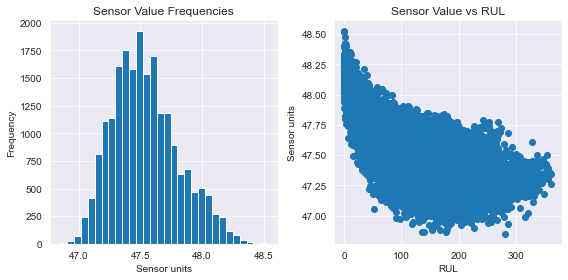

In [46]:
# Plot distribution and scatter plots for as-is sensor values
x = failure_df['RUL']
series1 = failure_df['sensor_11']

plot_sensor_curves(series1, x)

The scatter plot has a decay curve similar to the exponential curve as shown in the chart below on the left:



In [47]:
def plot_dummy_curves(a, b, b2):
    """ This function plots a scatter plot for variables a and b, then a and b2
    """
    plt.subplots(1, 2, figsize=(8,4))  # one row, two columns

    plt.subplot(1, 2, 1)  # in my 1x2 grid of plots, what's in slot 1?
    plt.scatter(a,b)
    plt.title('Dummy Sensor Value Before Transformation')
    plt.xlabel('RUL')
    plt.ylabel('Dummy Sensor units')
       
    plt.subplot(1, 2, 2)  # in my 1x2 grid of plots, what's in slot 2?
    plt.scatter(a,b2)
    plt.title('Dummy Sensor Value After Transformation')
    plt.xlabel('RUL')
    plt.ylabel('Dummy Sensor units')

    # comment out the following line and run cell to see the difference it makes
    plt.tight_layout()  # makes sure there is no overlap in plots

    plt.show()

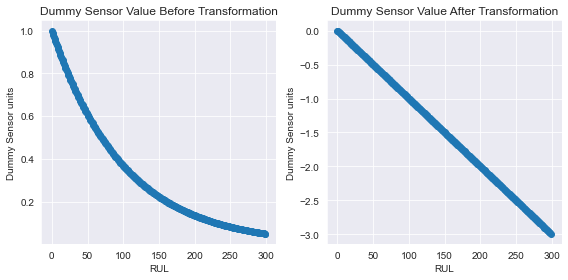

In [48]:
# Create appropriate model variables
a= np.arange(0,300)
b = np.exp(-a/100)
b2=np.log(b)

plot_dummy_curves(a,b,b2)

Based on the chart above on the right, a log transformation on the sensor data might work to straighten the data.

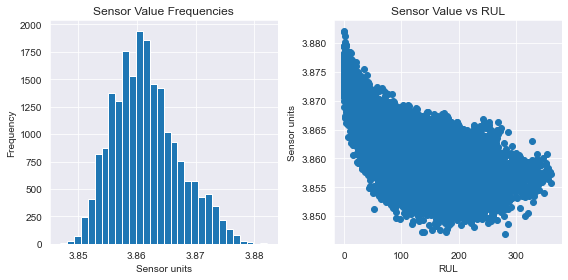

In [49]:
# Check transformation for fit to data
x = failure_df['RUL']
series2 = np.log(failure_df['sensor_11'])

plot_sensor_curves(series2, x)


Howerver the shape of the distribution has not changed significantly.

The attempt to transform the signals from `Sensor 12` appear to work better.  The initial distributions are shown below.

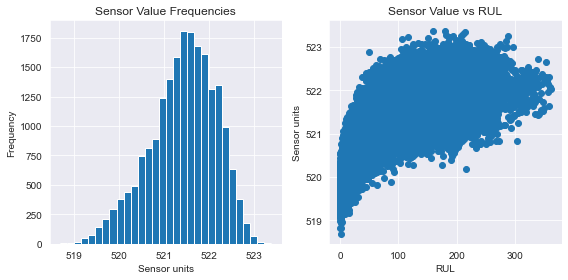

In [50]:
# Plot distribution and scatter plots for as-is sensor values
series1 = failure_df['sensor_12']
plot_sensor_curves(series1, x)

The transformation required looks to be an exponential version of the sensor values as shown below.

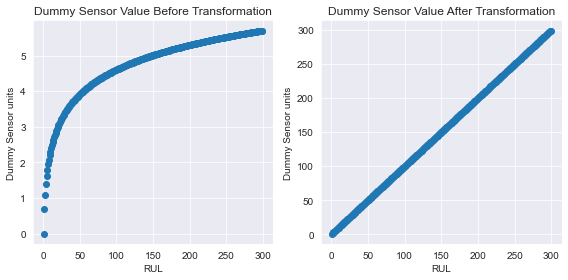

In [51]:
# Create appropriate model variables
a= np.arange(1,300)
b = np.log(a)
b2 = np.exp(b)

plot_dummy_curves(a,b,b2)

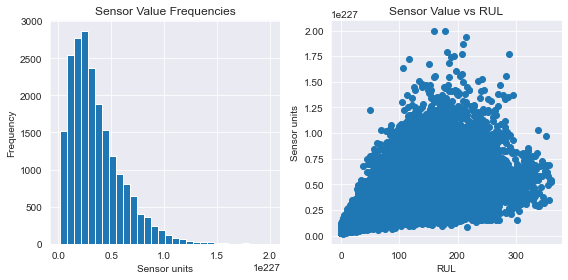

In [52]:
# Check transformation for fit to data
x = failure_df['RUL']
series2 = np.exp(failure_df['sensor_12'])

plot_sensor_curves(series2, x)

Applying this transformation does straighen out the relationship with RUL, while the distribution itself becomes heavily right-skewed. The scatter in the exponential plot however is extreme.  Not surprisingly, the linear regression model using this data does not score well, nor do the predictions of RUL improve.

In [53]:
### Test transformation for Regression modeling

# Set data
X_exp_model = series2
X_exp_model.head()
y = failure_df['RUL']

# Train the model and report results
X_exp_model_wc = sm.add_constant(X_exp_model)
linreg_exp1 = linear_model.OLS(y, X_exp_model_wc).fit()

# Train the model on existing data
y_pred_train_exp = linreg_exp1.predict(X_exp_model_wc)

linreg_exp1.summary()

C:\Users\Adams\.conda\envs\csadams\lib\site-packages\statsmodels\regression\linear_model.py:1901: RuntimeWarning: overflow encountered in square
  eigvals = self._wexog_singular_values ** 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 24 Jul 2022   Prob (F-statistic):                nan
Time:                        12:02:55   Log-Likelihood:            -1.1434e+05
No. Observations:               20631   AIC:                         2.287e+05
Df Residuals:                   20630   BIC:                         2.287e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        nan           0           0
sensor_12  2.598e-225          0        inf      0.000    2.6e-225    2.6e-225
==============================================================================
Omnibus:                      937.123   Durbin-Watson:                   0.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2557.596
Skew:                           0.219   Prob(JB):                         0.00
Kurtosis:                       4.668   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,    inf. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R2 value is 0.20. The predicted values show a high bias at zero but alarmingly broad fan-like predictions

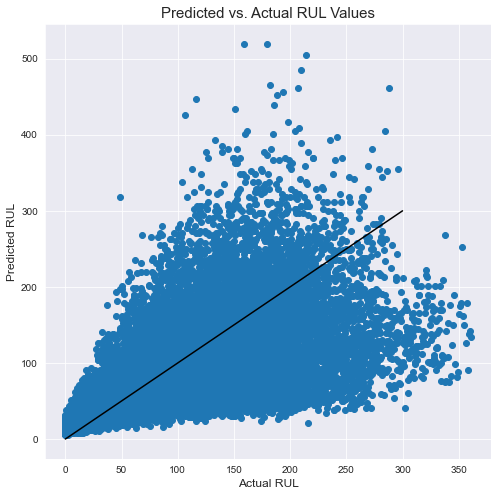

In [54]:
# Train the model on existing data
y_pred_train_exp = linreg_exp1.predict(X_exp_model_wc)

# Plot the results against training set...
a = np.arange(0,300,0.1)
b = a

plt.figure(figsize=(8,8))
plt.scatter(y, y_pred_train_exp)
plt.title('Predicted vs. Actual RUL Values', size=15)
plt.xlabel('Actual RUL', size=12)
plt.ylabel('Predicted RUL', size=12)
plt.plot(a, b, color='black')
plt.show()


Finally, the residuals are not normal or homoscedastic.

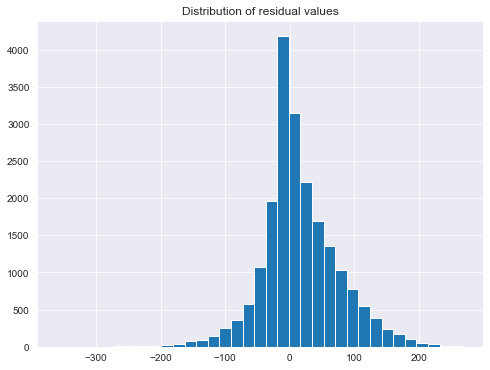

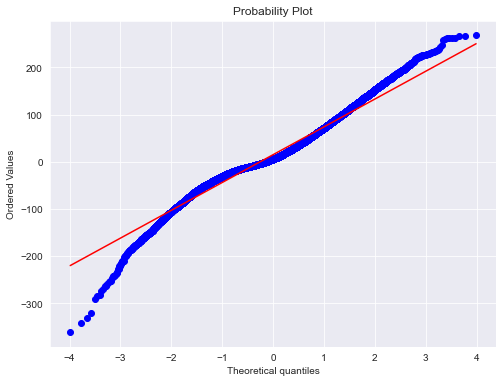

Shapiro-Wilk Test:  ShapiroResult(statistic=0.9694642424583435, pvalue=0.0)


C:\Users\Adams\.conda\envs\csadams\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


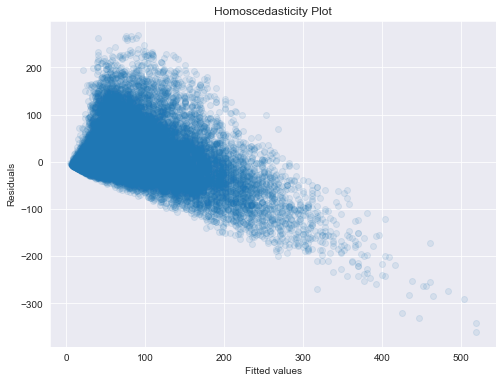

In [55]:
# Check residuals
residual_check(linreg_exp1)

The attempts at transforming the data do not appear to be leading in the right direction, probably related to the fact that the data points are noisy, are not independent and follow their own trajectories. This is also likely why people are looking at Deep Learning regression models to help with non-linearity instead.
